# Deep Reinforcement Learning for Ethereum Trading
## 15-Day State Space Methodology Implementation

This notebook implements a comprehensive Deep Reinforcement Learning (DRL) approach for Ethereum trading based on academic research methodology. The implementation follows "Reinforcement Learning Pair Trading: A Dynamic Scaling Approach" with significant enhancements for cryptocurrency markets.

### 📋 **Methodology Overview**

**State Space (15D)**: Comprehensive feature set including:
- Core Features: Position, Z-score, Normalized Zone, Price Momentum, Z-score Momentum, Position Change
- Technical Indicators: MACD (3 components), RSI, Bollinger Bands (3 components), OBV
- Sentiment Data: Social Media Sentiment Score (Reddit)

**Action Space**: Continuous [-1, 1] with maximum position shift constraint (0.1 per minute)

**Reward Function**: Multi-component hybrid signal:
- Primary: Profit-and-Loss (PnL) with normalization
- Risk-Adjusted: Differential Sharpe Ratio
- Penalties: Transaction costs, Drawdown penalties, Holding penalties
- Incentives: Activity rewards

**Training Protocol**: 
- Rolling window training (6-12 months)
- Temporal data splits (70% train, 15% validation, 15% test)
- Combinatorial Purged Cross-Validation (CPCV)
- Episode length: 28 days (40,320 minutes)

---

## 🏗️ **Notebook Structure**
1. **Imports & Configuration** - Dependencies and global parameters
2. **Data Loading & Preprocessing** - ETH data with technical indicators
3. **Feature Engineering** - 15D state space construction
4. **Environment Definition** - Custom trading environment
5. **Model Architecture** - A2C/TD3 implementations
6. **Training Pipeline** - Rolling window training
7. **Hyperparameter Optimization** - Bulk configuration testing
8. **Evaluation & Analysis** - Performance metrics and visualization
9. **Sentiment Integration** - Placeholder for Reddit sentiment data

---

### 🎯 **Key Features**
- ✅ Complete 15D state space as per methodology
- ✅ Multi-component reward function optimization
- ✅ Rolling window training protocol
- ✅ Comprehensive hyperparameter testing (1000 configs)
- ✅ Advanced risk management
- ✅ Temporal data splitting
- 🔄 Sentiment data integration (placeholder)

---

*Implementation Status: Core methodology complete, ready for sentiment data integration*


In [1]:
%pip install torch numpy pandas matplotlib seaborn plotly scikit-learn stable-baselines3 gymnasium pyarrow ta

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: C:\Users\77358\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
# ===================== IMPORTS & DEPENDENCIES =====================
# Core libraries
import os
import sys
import time
import json
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Any, Union
import warnings
warnings.filterwarnings('ignore')

# Machine Learning & Deep Reinforcement Learning
import torch
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import A2C, TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold, BaseCallback
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.utils import set_random_seed

# Data Processing & Technical Analysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import ta  # Technical Analysis library

# Visualization & Analysis
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Statistical Analysis
from scipy import stats
from scipy.optimize import minimize
# import statsmodels.api as sm

# Parallel Processing
from multiprocessing import Pool, cpu_count
from concurrent.futures import ProcessPoolExecutor, as_completed
import joblib

# Progress tracking
from tqdm.auto import tqdm

# Set random seeds for reproducibility
RANDOM_SEED = 42
set_random_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configure plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['figure.dpi'] = 100
sns.set_palette("husl")

def unwrap_env(e):
    """
    递归解包 Stable-Baselines3 的环境包装器，返回最里层的原始环境实例。
    兼容 DummyVecEnv/SubprocVecEnv + Monitor + 自定义 wrapper。
    """
    # VecEnv: 取第一个子环境
    if hasattr(e, "envs"):           # DummyVecEnv/SubprocVecEnv
        e = e.envs[0]
        return unwrap_env(e)

    # Gymnasium / Gym 常见包装器：.env 指向下一层
    if hasattr(e, "env"):
        try:
            # 防死循环：如果 e.env 就是 e 本身，直接返回
            if e.env is e:
                return e
            return unwrap_env(e.env)
        except Exception:
            return e

    # 有些包装器用 .venv / .unwrapped
    if hasattr(e, "venv"):
        return unwrap_env(e.venv)
    if hasattr(e, "unwrapped"):
        return e.unwrapped

    return e  # 已经是最里层


def safe_getattr(obj, name, default=None):
    try:
        return getattr(obj, name)
    except Exception:
        return default


print("✅ All imports loaded successfully")
print(f"🎲 Random seed set to: {RANDOM_SEED}")
print(f"💻 Available CPU cores: {cpu_count()}")
print(f"🐍 Python version: {sys.version}")
print(f"📊 NumPy version: {np.__version__}")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"🏋️ Gymnasium version: {gym.__version__}")
print(f"🧠 Stable-Baselines3 available")


✅ All imports loaded successfully
🎲 Random seed set to: 42
💻 Available CPU cores: 32
🐍 Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
📊 NumPy version: 1.26.4
🐼 Pandas version: 2.3.2
🏋️ Gymnasium version: 1.2.0
🧠 Stable-Baselines3 available


In [3]:
# ===================== CONFIGURATION & PARAMETERS =====================

# ==================== DATA CONFIGURATION ====================
# Path to preprocessed ETH data with technical indicators
DATA_PATH = "../ETHUSDT_1m_with_indicators.parquet"
TIMESTAMP_COL = "ts"                    # Timestamp column name
PRICE_COL = "close"                     # Primary price column
OUTPUT_DIR = "./processed_data_15d"     # Output directory for processed data
MODEL_DIR = "./models"                  # Directory for saved models
CONFIG_FILE = "./drl_training_configs.json"  # Hyperparameter configurations

# ==================== STATE SPACE CONFIGURATION (15D) ====================
# Core Features (6 dimensions)
MA_PERIOD = 60                          # Moving average period for Z-score baseline
Z_SCORE_WINDOW = 120                    # Rolling window for Z-score calculation (2 hours)
LOOKBACK_WINDOW = 120                   # State representation lookback (2 hours minimum)

# Zone thresholds for normalized zone calculation
OPEN_THRESHOLD = 2.0                    # Z-score threshold to open positions (±2.0)
CLOSE_THRESHOLD = 0.5                   # Z-score threshold to close positions (±0.5)

# Technical Indicators (8 dimensions)
# MACD: 3 components (MACD, Signal, Histogram)
# RSI: 1 component
# Bollinger Bands: 3 components (Middle, Upper, Lower)
# OBV: 1 component

# Sentiment Data (1 dimension)
SENTIMENT_WEIGHT = 0.15                 # Weight for sentiment in Fear & Greed Index

# ==================== ACTION SPACE CONFIGURATION ====================
# Continuous action space [-1, 1]
MAX_POSITION_SHIFT = 0.1                # Maximum position change per minute (as per methodology)
ACTION_NOISE_STD = 0.1                  # Action noise for exploration

# ==================== REWARD FUNCTION CONFIGURATION ====================
# Multi-component reward system weights
REWARD_COMPONENTS = {
    # Primary Reward: Profit-and-Loss
    'pnl_scale': 3000.0,                 # PnL reward scaling factor
    'pnl_normalization': 'nav',         # Normalization method ('nav', 'portfolio', 'none')
    
    # Risk-Adjusted Return (Differential Sharpe Ratio)
    'sharpe_weight': 0.2,               # Weight for Sharpe ratio component
    'sharpe_window': 1440,              # Window for Sharpe calculation (24 hours)
    
    # Transaction Costs Penalty
    'transaction_penalty': 0.0,         # Base transaction cost multiplier
    'fee_rate': 0.000,                  # Trading fee rate (0.1%)
    'slippage': 0.0000,                 # Market impact slippage (0.05%)
    
    # Drawdown Penalty
    'drawdown_threshold': 0.10,         # Drawdown threshold (10%)
    'drawdown_penalty': 5.0,           # Large negative reward for exceeding threshold
    
    # Holding Reward/Penalty
    'holding_penalty': 0.001,           # Penalty for prolonged inactivity
    'holding_reward': 0.0005,           # Bonus for profitable positions
    'max_hold_periods': 1440,           # Maximum hold duration (24 hours)
    
    # Activity Incentives
    'activity_reward': 0.001,             # Reward for taking action
    'inactivity_penalty': 0.005,        # Escalating penalty for inactivity

    # Sentiment Reward Feedback
    'enable_sentiment_reward': True,   # Optional toggle
    'sentiment_reward_weight': 0.0,     # Tunable multiplier

}

# ==================== TRADING PARAMETERS ====================
INITIAL_CAPITAL = 10000.0               # Initial portfolio value
EPISODE_LENGTH = 1440 * 7                  # Episode length in minutes (28 days)
POSITION_LIMITS = (-1.0, 1.0)          # Position limits

# ==================== TRAINING PROTOCOL CONFIGURATION ====================
# Data Splitting Strategy (Strict Chronological Order)
TRAIN_RATIO = 0.70                      # Training set: 70% of data (~2.6 years)
VALIDATION_RATIO = 0.15                 # Validation set: 15% of data (~7 months)  
TEST_RATIO = 0.15                       # Test set: 15% of data (~7 months)

# Rolling Window Training
ROLLING_WINDOW_MONTHS = 6              # Rolling window size (6-12 months)
EVALUATION_PERIOD_MONTHS = 1           # Evaluation period (1 month)
ROLLING_STEP_MONTHS = 1                 # Step size for rolling (1 month)

# Combinatorial Purged Cross-Validation (CPCV)
N_PURGED_SEGMENTS = 10                  # Number of segments for CPCV
PURGE_PERIODS = 1440                    # Purge periods (24 hours)
EMBARGO_PERIODS = 720                   # Embargo periods (12 hours)

# Episode and State Design
STATE_LOOKBACK_HOURS = 2                # State lookback (minimum for Z-score)

# ==================== MODEL HYPERPARAMETERS ====================
# A2C Default Parameters
A2C_PARAMS = {
    'learning_rate': 3e-4,
    'n_steps': 2048,
    'gamma': 0.99,
    'gae_lambda': 0.95,
    'ent_coef': 0.01,
    'vf_coef': 0.5,
    'max_grad_norm': 0.5,
    'normalize_advantage': True,
    'use_rms_prop': True,
    'use_sde': False,
}

# TD3 Default Parameters  
TD3_PARAMS = {
    'learning_rate': 3e-4,
    'buffer_size': 1000000,
    'learning_starts': 10000,
    'batch_size': 256,
    'tau': 0.005,
    'gamma': 0.99,
    'train_freq': 1,
    'gradient_steps': 1,
    'noise_std': 0.1,
    'target_noise': 0.2,
    'noise_clip': 0.5,
    'policy_delay': 2,
}

# Training Configuration
TRAINING_CONFIG = {
    'total_timesteps': 200000,           # Default training timesteps
    'eval_freq': 10000,                  # Evaluation frequency
    'n_eval_episodes': 10,               # Number of evaluation episodes
    'eval_log_path': './logs',           # Evaluation log path
    'save_freq': 25000,                  # Model save frequency
    'verbose': 1,                        # Verbosity level
}

# ==================== BULK TESTING CONFIGURATION ====================
BULK_CONFIG = {
    'max_parallel_jobs': min(cpu_count() - 1, 8),  # Parallel jobs for bulk testing
    'config_batch_size': 10,             # Batch size for configuration testing
    'early_stopping_patience': 3,        # Early stopping patience
    'performance_metric': 'sharpe_ratio', # Primary metric for optimization
    'min_evaluation_episodes': 5,        # Minimum episodes for evaluation
    'results_file': 'bulk_results.json', # Results output file
}

# ==================== FEATURE ENGINEERING CONFIGURATION ====================
FEATURE_CONFIG = {
    'normalization_method': 'robust',    # Normalization method ('standard', 'minmax', 'robust')
    'feature_selection': True,           # Enable feature selection
    'correlation_threshold': 0.95,       # Correlation threshold for feature removal
    'variance_threshold': 0.01,          # Variance threshold for feature removal
    'pca_components': None,              # PCA components (None = disabled)
}

# ==================== SENTIMENT INTEGRATION CONFIGURATION ====================
SENTIMENT_CONFIG = {
    'enabled': True,                     # Enable sentiment features (placeholder)
    'data_path': '../sentiment_1min_vader_s1_s5.csv',  # Path to sentiment data
    'aggregation_method': 'weighted_mean', # Aggregation method for sentiment scores
    'time_window': 60,                   # Time window for sentiment aggregation (minutes)
    'smoothing_factor': 0.1,             # Exponential smoothing factor
    'sentiment_features': [              # Sentiment feature columns (placeholder)
        'reddit_sentiment_score',
        'reddit_compound_score', 
        'reddit_post_volume',
        'reddit_comment_sentiment'
    ]
}

# Create output directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs('./logs', exist_ok=True)

print("🔧 Configuration loaded successfully!")
print(f"📊 State Space Dimensions: 15D")
print(f"   - Core Features: 6D (Position, Z-score, Zone, Price Momentum, Z-score Momentum, Position Change)")
print(f"   - Technical Indicators: 8D (MACD×3, RSI×1, BB×3, OBV×1)")
print(f"   - Sentiment Data: 1D (Reddit Sentiment)")
print(f"💰 Trading Configuration:")
print(f"   - Initial Capital: ${INITIAL_CAPITAL:,.0f}")
print(f"   - Episode Length: {EPISODE_LENGTH:,} minutes (28 days)")
print(f"   - Max Position Shift: {MAX_POSITION_SHIFT} per minute")
print(f"🎯 Reward Function: Multi-component hybrid (6 components)")
print(f"📅 Training Protocol: Rolling window ({ROLLING_WINDOW_MONTHS} months)")
print(f"💻 Parallel Processing: {BULK_CONFIG['max_parallel_jobs']} cores")
print(f"🔄 Sentiment Integration: {'Enabled' if SENTIMENT_CONFIG['enabled'] else 'Disabled'} (placeholder)")
print(f"📁 Output Directory: {OUTPUT_DIR}")


🔧 Configuration loaded successfully!
📊 State Space Dimensions: 15D
   - Core Features: 6D (Position, Z-score, Zone, Price Momentum, Z-score Momentum, Position Change)
   - Technical Indicators: 8D (MACD×3, RSI×1, BB×3, OBV×1)
   - Sentiment Data: 1D (Reddit Sentiment)
💰 Trading Configuration:
   - Initial Capital: $10,000
   - Episode Length: 10,080 minutes (28 days)
   - Max Position Shift: 0.1 per minute
🎯 Reward Function: Multi-component hybrid (6 components)
📅 Training Protocol: Rolling window (6 months)
💻 Parallel Processing: 8 cores
🔄 Sentiment Integration: Enabled (placeholder)
📁 Output Directory: ./processed_data_15d


In [4]:
# ===================== DATA LOADING & PREPROCESSING =====================

def load_eth_data(data_path: str) -> pd.DataFrame:
    """
    Load and preprocess ETH/USDT 1-minute data with technical indicators.
    
    Args:
        data_path: Path to the ETH data file
        
    Returns:
        pd.DataFrame: Cleaned and preprocessed data
    """
    print(f"📁 Loading data from: {data_path}")
    
    # Check if file exists
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data file not found: {data_path}")
    
    # Load data
    df = pd.read_parquet(data_path)
    
    # Handle timestamp column and reset index if needed
    if df.index.name == TIMESTAMP_COL or 'ts' in str(df.index.name) or isinstance(df.index, pd.DatetimeIndex):
        print(f"   🔧 Found timestamp in index, converting to column")
        df = df.reset_index()  # Convert index to column (don't drop it!)
    
    # Clean column names
    df.columns = df.columns.str.strip()
    
    # Check for timestamp column
    if TIMESTAMP_COL not in df.columns:
        # Try to find timestamp column
        possible_ts_cols = ['timestamp', 'ts', 'time', 'date', 'datetime']
        for col in possible_ts_cols:
            if col in df.columns:
                print(f"   🔧 Found timestamp column: '{col}', renaming to '{TIMESTAMP_COL}'")
                df = df.rename(columns={col: TIMESTAMP_COL})
                break
        else:
            raise ValueError(f"Could not find timestamp column. Available columns: {list(df.columns)}")
    
    # Basic preprocessing
    df = df.dropna()  # Remove any NaN values
    df = df.reset_index(drop=True)  # Reset row index
    
    # Ensure required columns are present
    required_cols = [PRICE_COL, 'volume']
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in data")
    
    # Sort by timestamp and clean price data
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    df[PRICE_COL] = pd.to_numeric(df[PRICE_COL], errors='coerce')
    df = df.dropna(subset=[PRICE_COL])
    df = df[df[PRICE_COL] > 0]
    
    print(f"   ✅ Loaded {len(df):,} rows of data")
    print(f"   📊 Columns: {list(df.columns)}")
    
    # Display date range if possible
    if TIMESTAMP_COL in df.columns:
        if df[TIMESTAMP_COL].dtype == 'int64':
            # Convert Unix timestamp to datetime for display
            start_date = pd.to_datetime(df[TIMESTAMP_COL].min(), unit='s')
            end_date = pd.to_datetime(df[TIMESTAMP_COL].max(), unit='s')
            print(f"   📅 Date range: {start_date} to {end_date}")
        elif pd.api.types.is_datetime64_any_dtype(df[TIMESTAMP_COL]):
            print(f"   📅 Date range: {df[TIMESTAMP_COL].min()} to {df[TIMESTAMP_COL].max()}")
    
    return df

def calculate_core_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate core features (6 dimensions) as per methodology.
    Features 1 & 6 (position, position_change) will be added by the environment.
    
    Core Features:
    2. Z-score: Standardized mean-reversion signal
    3. Normalized Zone: Discrete trading signal
    4. Price Momentum: Last-minute price return
    5. Z-score Momentum: One-minute change in Z-score
    
    Args:
        df: DataFrame with price data
        
    Returns:
        DataFrame with core features added
    """
    print("   🔬 Calculating core features (6D)...")
    
    # Calculate pseudo-spread and Z-score
    # Step 1: Moving average (baseline for pseudo-spread)
    df['ma_baseline'] = df[PRICE_COL].rolling(window=MA_PERIOD, min_periods=1).mean()
    
    # Step 2: Spread (price deviation from MA) 
    df['spread'] = df[PRICE_COL] - df['ma_baseline']
    
    # Step 3: Z-score (standardized spread over rolling window)
    spread_mean = df['spread'].rolling(window=Z_SCORE_WINDOW, min_periods=1).mean()
    spread_std = df['spread'].rolling(window=Z_SCORE_WINDOW, min_periods=1).std()
    df['z_score'] = (df['spread'] - spread_mean) / (spread_std + 1e-8)
    df['z_score'] = df['z_score'].fillna(0)  # Fill NaN with neutral value
    
    # Feature 3: Normalized Zone
    def calculate_trading_zone(z_score):
        if z_score > OPEN_THRESHOLD:
            return 1.0  # Strong sell signal
        elif z_score > CLOSE_THRESHOLD:
            return 0.5  # Weak sell signal
        elif z_score >= -CLOSE_THRESHOLD:
            return 0.0  # Neutral (close positions)
        elif z_score >= -OPEN_THRESHOLD:
            return -0.5  # Weak buy signal
        else:
            return -1.0  # Strong buy signal
    
    df['zone_norm'] = df['z_score'].apply(calculate_trading_zone)
    
    # Feature 4: Price Momentum (last-minute price return)
    df['price_momentum'] = df[PRICE_COL].pct_change(1).fillna(0)
    df['price_momentum'] = df['price_momentum'].clip(-0.1, 0.1)  # Clip for numerical stability
    
    # Feature 5: Z-score Momentum (one-minute change in Z-score)
    df['z_score_momentum'] = df['z_score'].diff(1).fillna(0)
    df['z_score_momentum'] = df['z_score_momentum'].clip(-2.0, 2.0)  # Clip extreme values
    
    # Clean up intermediate columns
    df = df.drop(['ma_baseline', 'spread'], axis=1)
    
    print(f"      ✅ Z-score range: [{df['z_score'].min():.2f}, {df['z_score'].max():.2f}]")
    print(f"      ✅ Zone distribution: {df['zone_norm'].value_counts().to_dict()}")
    print(f"      ✅ Price momentum range: [{df['price_momentum'].min():.4f}, {df['price_momentum'].max():.4f}]")
    
    return df

def calculate_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate technical indicators (8 dimensions) as per methodology.
    
    Technical Indicators:
    7. MACD Line (normalized)
    8. MACD Signal (normalized) 
    9. MACD Histogram (normalized)
    10. RSI (normalized)
    11. Bollinger Bands Mid (normalized)
    12. Bollinger Bands High (normalized)
    13. Bollinger Bands Low (normalized)
    14. OBV (normalized)
    
    Args:
        df: DataFrame with OHLCV data
        
    Returns:
        DataFrame with technical indicators added
    """
    print("   📈 Calculating technical indicators (8D)...")
    
    # Check for required columns
    required_cols = ['open', 'high', 'low', 'close', 'volume']
    missing_cols = [col for col in required_cols if col not in df.columns]
    
    if missing_cols:
        print(f"      ⚠️ Missing columns for technical indicators: {missing_cols}")
        print("      📊 Available columns:", list(df.columns))
        
        # Use existing indicator columns if available
        if all(col in df.columns for col in ['MACD', 'MACD_signal', 'MACD_diff']):
            df['macd_norm'] = df['MACD']
            df['macd_signal_norm'] = df['MACD_signal']
            df['macd_diff_norm'] = df['MACD_diff']
            print("      ✅ Using existing MACD indicators")
        else:
            # Calculate MACD manually using close prices
            ema12 = df['close'].ewm(span=12).mean()
            ema26 = df['close'].ewm(span=26).mean()
            df['macd_norm'] = ema12 - ema26
            df['macd_signal_norm'] = df['macd_norm'].ewm(span=9).mean()
            df['macd_diff_norm'] = df['macd_norm'] - df['macd_signal_norm']
            print("      ✅ Calculated MACD from close prices")
        
        # RSI calculation
        if 'RSI' in df.columns:
            df['rsi_norm'] = df['RSI'] / 100.0  # Normalize to [0,1]
            print("      ✅ Using existing RSI indicator")
        else:
            # Calculate RSI manually
            delta = df['close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / (loss + 1e-8)  # Add small epsilon to avoid division by zero
            df['rsi_norm'] = (1 - (1 / (1 + rs)))
            print("      ✅ Calculated RSI from close prices")
        
        # Bollinger Bands
        if all(col in df.columns for col in ['BB_mid', 'BB_high', 'BB_low']):
            df['bb_mid_norm'] = df['BB_mid']
            df['bb_high_norm'] = df['BB_high'] 
            df['bb_low_norm'] = df['BB_low']
            print("      ✅ Using existing Bollinger Bands")
        else:
            # Calculate Bollinger Bands
            bb_period = 20
            bb_std = 2
            df['bb_mid_norm'] = df['close'].rolling(window=bb_period).mean()
            bb_std_val = df['close'].rolling(window=bb_period).std()
            df['bb_high_norm'] = df['bb_mid_norm'] + (bb_std_val * bb_std)
            df['bb_low_norm'] = df['bb_mid_norm'] - (bb_std_val * bb_std)
            print("      ✅ Calculated Bollinger Bands from close prices")
        
        # OBV calculation
        if 'volume' in df.columns:
            # Calculate OBV efficiently
            price_change = df['close'].diff()
            volume_direction = np.where(price_change > 0, df['volume'], 
                                      np.where(price_change < 0, -df['volume'], 0))
            df['obv_norm'] = volume_direction.cumsum()
            print("      ✅ Calculated OBV from volume data")
        else:
            # Create dummy OBV if no volume data
            df['obv_norm'] = 0
            print("      ⚠️ No volume data - using dummy OBV")
            
    else:
        # Calculate all indicators using ta library
        print("      📊 Full OHLCV data available - calculating comprehensive indicators")
        
        try:
            # 1-3. MACD (3 components)
            macd = ta.trend.MACD(df['close'])
            df['macd_norm'] = macd.macd()
            df['macd_signal_norm'] = macd.macd_signal()
            df['macd_diff_norm'] = macd.macd_diff()
            
            # 4. RSI
            df['rsi_norm'] = ta.momentum.RSIIndicator(df['close']).rsi() / 100.0  # Normalize to [0,1]
            
            # 5-7. Bollinger Bands (3 components)
            bb = ta.volatility.BollingerBands(df['close'])
            df['bb_mid_norm'] = bb.bollinger_mavg()
            df['bb_high_norm'] = bb.bollinger_hband()
            df['bb_low_norm'] = bb.bollinger_lband()
            
            # 8. OBV
            df['obv_norm'] = ta.volume.OnBalanceVolumeIndicator(df['close'], df['volume']).on_balance_volume()
            
        except Exception as e:
            print(f"      ⚠️ Error calculating technical indicators with ta library: {e}")
            # Create placeholder features if calculation fails
            for indicator in ['macd_norm', 'macd_signal_norm', 'macd_diff_norm', 'rsi_norm', 
                             'bb_mid_norm', 'bb_high_norm', 'bb_low_norm', 'obv_norm']:
                df[indicator] = 0.0
    
    # Normalize all technical indicators
    tech_indicators = ['macd_norm', 'macd_signal_norm', 'macd_diff_norm', 'rsi_norm', 
                      'bb_mid_norm', 'bb_high_norm', 'bb_low_norm', 'obv_norm']
    
    for indicator in tech_indicators:
        if indicator in df.columns:
            # Robust normalization (clip outliers, then normalize)
            q99 = df[indicator].quantile(0.99)
            q01 = df[indicator].quantile(0.01)
            df[indicator] = df[indicator].clip(q01, q99)
            
            # Min-max normalization to [-1, 1] range
            min_val = df[indicator].min()
            max_val = df[indicator].max()
            if max_val > min_val:
                df[indicator] = 2 * (df[indicator] - min_val) / (max_val - min_val) - 1
            else:
                df[indicator] = 0
            
            df[indicator] = df[indicator].fillna(0)
    
    print(f"      ✅ Technical indicators calculated and normalized")
    print(f"      📊 Indicators: {len(tech_indicators)} components")
    
    return df

def integrate_sentiment_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Integrate minute-level sentiment data into the feature set.
    
    Args:
        df: DataFrame with price and technical features
        
    Returns:
        DataFrame with sentiment_score feature added
    """
    print("   🔄 Integrating sentiment data (1D)...")

    if not SENTIMENT_CONFIG.get("enabled", False):
        df["sentiment_score"] = 0.0
        print("      ⚠️ Sentiment disabled – using neutral value 0.0")
        return df

    data_path = SENTIMENT_CONFIG.get("data_path")
    if not data_path or not os.path.exists(data_path):
        print("      ⚠️ Sentiment file missing – using 0.0")
        df["sentiment_score"] = 0.0
        return df

    try:
        sentiment_df = pd.read_csv(data_path)
    except Exception as exc:
        print(f"      ⚠️ Failed to load sentiment data: {exc} - defaulting to 0.0")
        df['sentiment_score'] = 0.0
        return df

    if TIMESTAMP_COL not in sentiment_df.columns:
        raise ValueError(f"Sentiment file must include '{TIMESTAMP_COL}' column")

    # Process sentiment data
    sentiment_df[TIMESTAMP_COL] = pd.to_datetime(sentiment_df[TIMESTAMP_COL])
    sentiment_cols = [c for c in sentiment_df.columns if c != TIMESTAMP_COL]
    
    if not sentiment_cols:
        print("      ⚠️ No sentiment columns found - defaulting to 0.0")
        df['sentiment_score'] = 0.0
        return df
    
    # Aggregate to minute level and compute a single sentiment score
    sentiment_df = (
        sentiment_df.groupby(TIMESTAMP_COL)[sentiment_cols]
        .mean()
        .reset_index()
    )
    sentiment_df["sentiment_score"] = sentiment_df[sentiment_cols].mean(axis=1)

    # Handle timestamp compatibility for merging
    df_ts_dtype = df[TIMESTAMP_COL].dtype
    
    # Check if timestamp is numeric (Unix timestamp)
    if pd.api.types.is_numeric_dtype(df_ts_dtype):
        # Convert datetime to Unix timestamp to match df format
        sentiment_df[TIMESTAMP_COL] = (
            sentiment_df[TIMESTAMP_COL].view("int64") // 10**9
        ).astype(df_ts_dtype)
    else:
        # Both are datetime types - ensure they're compatible
        df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
        sentiment_df[TIMESTAMP_COL] = pd.to_datetime(sentiment_df[TIMESTAMP_COL])
        
        # Remove timezone info to make them compatible
        if hasattr(df[TIMESTAMP_COL].dtype, 'tz') and df[TIMESTAMP_COL].dtype.tz is not None:
            df[TIMESTAMP_COL] = df[TIMESTAMP_COL].dt.tz_localize(None)
        if hasattr(sentiment_df[TIMESTAMP_COL].dtype, 'tz') and sentiment_df[TIMESTAMP_COL].dtype.tz is not None:
            sentiment_df[TIMESTAMP_COL] = sentiment_df[TIMESTAMP_COL].dt.tz_localize(None)

    # Merge sentiment data
    df = df.merge(
        sentiment_df[[TIMESTAMP_COL, "sentiment_score"]],
        on=TIMESTAMP_COL,
        how="left",
    )
    coverage = df["sentiment_score"].notna().mean()
    df["sentiment_score"] = df["sentiment_score"].fillna(0.0)

    print(f"      ✅ Sentiment merged – coverage: {coverage:.1%}")
    return df

# ===================== MAIN EXECUTION =====================

def run_feature_engineering_pipeline():
    """Main execution pipeline for data loading and feature engineering."""
    
    print("🚀 Starting data loading and feature engineering...")
    
    # Load raw data
    df_raw = load_eth_data(DATA_PATH)
    
    print("\n🔧 Feature Engineering Pipeline (15D State Space):")
    df_processed = df_raw.copy()
    
    # Core features (6D) - 4 calculated here, 2 added by environment
    df_processed = calculate_core_features(df_processed)
    
    # Technical indicators (8D) 
    df_processed = calculate_technical_indicators(df_processed)
    
    # Sentiment data (1D)
    df_processed = integrate_sentiment_data(df_processed)
    
    # Define final feature columns for 15D state space
    FEATURE_COLUMNS = [
        # Core features (6D) - 4 calculated, 2 will be added by environment
        'z_score',           # Feature 2: Z-score signal
        'zone_norm',         # Feature 3: Normalized zone
        'price_momentum',    # Feature 4: Price momentum
        'z_score_momentum',  # Feature 5: Z-score momentum
        # Features 1 & 6 (position, position_change) added by environment
        
        # Technical indicators (8D)
        'macd_norm',         # Feature 7: MACD line
        'macd_signal_norm',  # Feature 8: MACD signal
        'macd_diff_norm',    # Feature 9: MACD histogram
        'rsi_norm',          # Feature 10: RSI
        'bb_mid_norm',       # Feature 11: Bollinger middle
        'bb_high_norm',      # Feature 12: Bollinger upper
        'bb_low_norm',       # Feature 13: Bollinger lower
        'obv_norm',          # Feature 14: OBV
        
        # Sentiment data (1D)
        'sentiment_score'    # Feature 15: Reddit sentiment
    ]
    
    # Verify all features are present
    missing_features = [col for col in FEATURE_COLUMNS if col not in df_processed.columns]
    if missing_features:
        print(f"\n❌ Missing features: {missing_features}")
    else:
        print(f"\n✅ All 15D features successfully calculated!")
    
    print(f"\n📊 Feature Engineering Summary:")
    print(f"   📈 Raw data: {len(df_raw):,} rows")
    print(f"   🔧 Processed data: {len(df_processed):,} rows") 
    print(f"   📋 Features: {len(FEATURE_COLUMNS)} dimensions")
    print(f"   🎯 State space: 15D (as per methodology)")
    print(f"   💾 Memory usage: {df_processed.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Save processed data
    processed_data_path = os.path.join(OUTPUT_DIR, 'processed_eth_data_15d.parquet')
    df_processed.to_parquet(processed_data_path, index=False)
    print(f"   💾 Processed data saved: {processed_data_path}")
    
    # Display sample of processed features
    print(f"\n📋 Sample of 15D Feature Data:")
    sample_features = df_processed[FEATURE_COLUMNS].tail()
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(sample_features)
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    
    print(f"\n🎯 Data ready for 15D state space training!")
    print(f"📊 Dataset shape: {df_processed.shape}")
    print(f"📅 Ready for temporal data splitting...")
    
    return df_processed, FEATURE_COLUMNS

# Execute the pipeline
if __name__ == "__main__":
    df_processed, feature_columns = run_feature_engineering_pipeline()

🚀 Starting data loading and feature engineering...
📁 Loading data from: ../ETHUSDT_1m_with_indicators.parquet
   🔧 Found timestamp in index, converting to column
   ✅ Loaded 1,883,407 rows of data
   📊 Columns: ['ts', 'open', 'high', 'low', 'close', 'volume', 'number_of_trades', 'symbol', 'RSI', 'BB_mid', 'BB_high', 'BB_low', 'EMA_12', 'EMA_26', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR']
   📅 Date range: 2022-01-01 00:33:00+00:00 to 2025-07-31 23:59:00+00:00

🔧 Feature Engineering Pipeline (15D State Space):
   🔬 Calculating core features (6D)...
      ✅ Z-score range: [-10.32, 10.36]
      ✅ Zone distribution: {0.0: 569097, -0.5: 568471, 0.5: 566294, -1.0: 92863, 1.0: 86682}
      ✅ Price momentum range: [-0.0959, 0.0635]
   📈 Calculating technical indicators (8D)...
      📊 Full OHLCV data available - calculating comprehensive indicators
      ✅ Technical indicators calculated and normalized
      📊 Indicators: 8 components
   🔄 Integrating sentiment data (1D)...
      ⚠️ Sentiment f

In [5]:
# ===================== TEMPORAL DATA SPLITTING =====================

def create_temporal_data_splits(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Create temporal data splits following methodology:
    - 70% Training data (strict chronological order)
    - 15% Validation data  
    - 15% Test data
    
    Args:
        df: Processed DataFrame with features
        
    Returns:
        Dictionary containing train, validation, test splits and metadata
    """
    print("🔄 Creating temporal data splits (70/15/15)...")
    
    total_rows = len(df)
    
    # Calculate split indices (strict chronological order)
    train_end_idx = int(total_rows * TRAIN_RATIO)
    val_end_idx = int(total_rows * (TRAIN_RATIO + VALIDATION_RATIO))
    
    # Create splits
    train_df = df.iloc[:train_end_idx].copy().reset_index(drop=True)
    val_df = df.iloc[train_end_idx:val_end_idx].copy().reset_index(drop=True)
    test_df = df.iloc[val_end_idx:].copy().reset_index(drop=True)
    
    # Calculate date ranges for metadata
    if TIMESTAMP_COL in df.columns:
        train_start = pd.to_datetime(train_df[TIMESTAMP_COL].iloc[0], unit='s')
        train_end = pd.to_datetime(train_df[TIMESTAMP_COL].iloc[-1], unit='s')
        val_start = pd.to_datetime(val_df[TIMESTAMP_COL].iloc[0], unit='s')
        val_end = pd.to_datetime(val_df[TIMESTAMP_COL].iloc[-1], unit='s')
        test_start = pd.to_datetime(test_df[TIMESTAMP_COL].iloc[0], unit='s')
        test_end = pd.to_datetime(test_df[TIMESTAMP_COL].iloc[-1], unit='s')
    else:
        train_start = train_end = val_start = val_end = test_start = test_end = None
    
    # Create metadata
    split_info = {
        'total_rows': total_rows,
        'train_rows': len(train_df),
        'val_rows': len(val_df),
        'test_rows': len(test_df),
        'train_ratio': len(train_df) / total_rows,
        'val_ratio': len(val_df) / total_rows,
        'test_ratio': len(test_df) / total_rows,
        'train_start_date': train_start.isoformat() if train_start else None,
        'train_end_date': train_end.isoformat() if train_end else None,
        'val_start_date': val_start.isoformat() if val_start else None,
        'val_end_date': val_end.isoformat() if val_end else None,
        'test_start_date': test_start.isoformat() if test_start else None,
        'test_end_date': test_end.isoformat() if test_end else None,
        'methodology_compliance': True,
        'chronological_order': True
    }
    
    print(f"   ✅ Training:   {len(train_df):,} rows ({len(train_df)/total_rows:.1%})")
    print(f"   ✅ Validation: {len(val_df):,} rows ({len(val_df)/total_rows:.1%})")
    print(f"   ✅ Test:       {len(test_df):,} rows ({len(test_df)/total_rows:.1%})")
    
    if train_start:
        print(f"   📅 Training period:   {train_start.strftime('%Y-%m-%d')} to {train_end.strftime('%Y-%m-%d')}")
        print(f"   📅 Validation period: {val_start.strftime('%Y-%m-%d')} to {val_end.strftime('%Y-%m-%d')}")
        print(f"   📅 Test period:       {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')}")
    
    # Save splits to files
    train_path = os.path.join(OUTPUT_DIR, 'train_data_15d.parquet')
    val_path = os.path.join(OUTPUT_DIR, 'val_data_15d.parquet')
    test_path = os.path.join(OUTPUT_DIR, 'test_data_15d.parquet')
    split_info_path = os.path.join(OUTPUT_DIR, 'temporal_split_info.json')
    
    train_df.to_parquet(train_path, index=False)
    val_df.to_parquet(val_path, index=False)
    test_df.to_parquet(test_path, index=False)
    
    with open(split_info_path, 'w') as f:
        json.dump(split_info, f, indent=2)
    
    print(f"   💾 Data splits saved to: {OUTPUT_DIR}")
    
    return {
        'train': train_df,
        'validation': val_df,
        'test': test_df,
        'split_info': split_info
    }

# Apply temporal data splitting
print("\n📊 Applying Temporal Data Splitting Protocol:")
data_splits = create_temporal_data_splits(df_processed)

# Extract data splits for easy access
train_data = data_splits['train']
val_data = data_splits['validation'] 
test_data = data_splits['test']
split_metadata = data_splits['split_info']

print(f"\n✅ Temporal data splitting complete!")
print(f"🎯 Ready for rolling window training implementation")
print(f"📋 Next: Custom trading environment with 15D state space")



📊 Applying Temporal Data Splitting Protocol:
🔄 Creating temporal data splits (70/15/15)...
   ✅ Training:   1,318,384 rows (70.0%)
   ✅ Validation: 282,511 rows (15.0%)
   ✅ Test:       282,512 rows (15.0%)
   📅 Training period:   2022-01-01 to 2024-07-04
   📅 Validation period: 2024-07-04 to 2025-01-16
   📅 Test period:       2025-01-16 to 2025-07-31
   💾 Data splits saved to: ./processed_data_15d

✅ Temporal data splitting complete!
🎯 Ready for rolling window training implementation
📋 Next: Custom trading environment with 15D state space


In [6]:
# ===================== CUSTOM TRADING ENVIRONMENT (15D STATE SPACE) =====================

class EthereumTradingEnvironment(gym.Env):
    """
    Custom Ethereum Trading Environment implementing 15D state space methodology.
    
    Features:
    - 15-dimensional state space (6 core + 8 technical + 1 sentiment)
    - Multi-component reward function with PnL-dominant shaping
    - Continuous action space [-1, 1] with fixed per-step position shift constraint
    - Rolling window training support
    - Advanced risk management & activity annealing/caps
    """
    metadata = {'render.modes': []}

    def __init__(self, 
                 data: pd.DataFrame,
                 feature_columns: List[str],
                 reward_config: Dict[str, float] = None,
                 episode_length: int = EPISODE_LENGTH,
                 lookback_window: int = LOOKBACK_WINDOW,
                 initial_capital: float = INITIAL_CAPITAL,
                 max_position_shift: float = MAX_POSITION_SHIFT,
                 random_start: bool = True):
        """
        Initialize Ethereum Trading Environment.
        """
        super().__init__()
        # ---- config ----
        self.data = data.copy()
        self.feature_columns = feature_columns
        self.reward_config = reward_config or REWARD_COMPONENTS
        self.episode_length = episode_length
        self.lookback_window = lookback_window
        self.initial_capital = initial_capital
        self.max_position_shift = float(max_position_shift)   # 固定单步限速
        self.random_start = random_start
        self.ema_alpha = 0.8  # 写死为常数

        # ---- cache ----
        self.prices = self.data[PRICE_COL].values
        self.timestamps = self.data[TIMESTAMP_COL].values if TIMESTAMP_COL in self.data.columns else None
        self.features = self.data[feature_columns].values  # 13D（position/position_change 动态补）

        # ---- spaces ----
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=np.array([-1.0, -5.0, -1.0, -0.1, -2.0, -0.2, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0], dtype=np.float32),
            high=np.array([ 1.0,  5.0,  1.0,  0.1,  2.0,  0.2,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0,  1.0], dtype=np.float32),
            dtype=np.float32
        )

        # ---- episode bounds ----
        self.min_start_idx = lookback_window
        self.max_start_idx = len(self.data) - episode_length - 1

        # ---- runtime ----
        self.reset()

        print(f"✅ EthereumTradingEnvironment initialized")
        print(f"   📊 Data length: {len(self.data):,} rows")
        print(f"   🎯 State space: 15D (6 core + 8 technical + 1 sentiment)")
        print(f"   🎮 Action space: Continuous [-1, 1]")
        print(f"   📏 Episode length: {episode_length} minutes")
        print(f"   🔙 Lookback window: {lookback_window} minutes")
        print(f"   💰 Initial capital: ${initial_capital:,.0f}")
        print(f"🚦 max_position_shift={self.max_position_shift}")

    def _get_state(self, current_idx: int) -> np.ndarray:
        """Construct 15D state representation."""
        current_features = self.features[current_idx].copy()
        state = np.zeros(15, dtype=np.float32)
        # 1. position
        state[0] = self.position
        # 2-5. core features
        state[1:5] = current_features[:4]
        # 6. position change
        state[5] = self.position_change
        # 7-14. technicals
        state[6:14] = current_features[4:12]
        # 15. sentiment
        state[14] = current_features[12]
        return np.clip(state, self.observation_space.low, self.observation_space.high)
    
    def _calculate_multi_component_reward(self, action: float, current_idx: int) -> Tuple[float, Dict[str, float]]:
        """
        固定单步限速；用中点暴露计 PnL；
        在奖励内进行“动作幅度塑形”（直接针对 raw action），
        并将活动项的驱动从“结果Δpos”转为“目标跳变为主（raw）+ 少量实际Δpos”。
        """
        # === 目标仓位（不在奖励外放大动作）===
        raw_action = float(np.asarray(action).item())
        target     = float(np.clip(raw_action, -1.0, 1.0))
        pre_pos    = self.position
    
        # === 自适应单步限速 + 动量推进（如你已有，否则保留固定上限即可）===
        z      = float(self.features[current_idx, 0])   # z_score
        z_abs  = abs(z)
        sig_k  = float(self.reward_config.get('signal_k', 1.2))
        s      = float(np.tanh(sig_k * z_abs))          # [0,1] 信号强度
    
        step_lo   = float(self.reward_config.get('step_lo', 0.35))
        step_hi   = float(self.reward_config.get('step_hi', 1.00))
        base_ms   = float(self.max_position_shift)
        eff_shift = base_ms * (step_lo + (step_hi - step_lo) * s)
    
        # 动量推进（可选）：沿真实步长方向再推一把
        beta_mom = float(self.reward_config.get('step_momentum_beta', 0.55))
        if not hasattr(self, "step_vel"):
            self.step_vel = 0.0
        proposed   = float(target - pre_pos) + beta_mom * float(self.step_vel)
    
        # 应用限速并更新仓位
        step       = float(np.clip(proposed, -eff_shift, eff_shift))
        post_pos   = float(np.clip(pre_pos + step, -1.0, 1.0))
        position_change = float(post_pos - pre_pos)
        self.step_vel   = position_change  # 记录真实步长作为动量
    
        # ===== 中点暴露 PnL =====
        if current_idx + 1 < len(self.prices):
            price_change = (self.prices[current_idx + 1] - self.prices[current_idx]) / self.prices[current_idx]
        else:
            price_change = 0.0
    
        exposure         = 0.5 * (pre_pos + post_pos)
        position_return  = exposure * price_change
        portfolio_change = position_return * self.portfolio_value
    
        # 1) PnL 奖励
        pnl_norm  = self.reward_config.get('pnl_normalization', 'nav')
        pnl_scale = float(self.reward_config.get('pnl_scale', 20000.0))
        if pnl_norm == 'nav':
            pnl_reward = (portfolio_change / self.initial_capital) * pnl_scale
        else:
            pnl_reward = portfolio_change * pnl_scale
    
        # 2) Sharpe 奖励
        sharpe_w      = float(self.reward_config.get('sharpe_weight', 0.2))
        sharpe_window = int(self.reward_config.get('sharpe_window', 240))
        if len(self.return_history) > 1:
            rr = np.array(self.return_history[-sharpe_window:])
            sharpe_reward = float(np.mean(rr) / np.std(rr)) * sharpe_w if (len(rr) > 1 and np.std(rr) > 0) else 0.0
        else:
            sharpe_reward = 0.0
    
        # 3) 交易成本惩罚（温和）
        fee = float(self.reward_config.get('fee_rate', 0.001) + self.reward_config.get('slippage', 0.0005))
        trade_cost = abs(position_change) * fee
        transaction_penalty = -trade_cost * self.portfolio_value * float(self.reward_config.get('transaction_penalty', 0.01)) * 0.1
    
        # 4) 回撤惩罚
        current_nav = self.portfolio_value / self.initial_capital
        dd_th  = float(self.reward_config.get('drawdown_threshold', 0.15))
        dd_pen = float(self.reward_config.get('drawdown_penalty', 0.10))
        drawdown_penalty = -dd_pen if current_nav < (self.peak_nav * (1 - dd_th)) else 0.0
    
        # 5) 持仓奖励/惩罚（可留空或维持你原逻辑）
        if abs(pre_pos) > 0.1:
            holding_reward = float(self.reward_config.get('holding_reward', 0.0)) if position_return > 0 else -float(self.reward_config.get('holding_penalty', 0.0))
        else:
            holding_reward = 0.0
        if self.steps_in_position > int(self.reward_config.get('max_hold_periods', 10_000_000)):
            holding_reward -= float(self.reward_config.get('holding_penalty', 0.0)) * 2
    
        # ============ 活动与门控塑形 ============
        activity_k     = float(self.reward_config.get('activity_k', 0.1))
        boost          = float(self.reward_config.get('activity_signal_boost', 0.5))
        inactivity_eps = float(self.reward_config.get('inactivity_eps', 0.005))
        inactivity_pen = float(self.reward_config.get('inactivity_penalty', 0.005))
    
        # 信号强度（0~1）
        signal_strength = min(abs(z), 3.0) / 3.0
    
        # ✅ 用“目标跳变”为主、叠加少量“实际Δpos”
        den_ms          = max(1e-8, float(self.max_position_shift))
        norm_change_raw  = float(min(1.0, abs(target - pre_pos)   / den_ms))  # 目标跳变
        norm_change_real = float(min(1.0, abs(position_change)    / den_ms))  # 实际结果
        norm_change      = 0.7 * norm_change_raw + 0.3 * norm_change_real
    
        base_activity = activity_k * norm_change * (1.0 + boost * signal_strength)
    
        # “不动”递增罚
        if abs(position_change) <= inactivity_eps:
            self.inactive_steps += 1
        else:
            self.inactive_steps = 0
        base_activity -= inactivity_pen * min(self.inactive_steps, 20) * 0.2
    
        # ---- 门控：强信号同向 → 大步加分；弱信号/反向 → 扣分 ----
        # 同向/中性判定
        z_eps, pos_eps = 1e-6, 1e-6
        if abs(z) <= z_eps or abs(post_pos) <= pos_eps:
            align = 0.5
        else:
            align = 1.0 if np.sign(z) == np.sign(post_pos) else 0.0
    
        # 门控开度
        gate_thr   = float(self.reward_config.get('gate_threshold', 0.8))
        gate_k     = float(self.reward_config.get('gate_k', 1.0))
        gate_floor = float(self.reward_config.get('gate_floor', 0.15))
        gate = 1.0 / (1.0 + np.exp(-gate_k * (abs(z) - gate_thr)))
        gate = max(gate, gate_floor)
    
        # 步长归一（基于实际结果，给大步塑形）
        norm_change_real = float(min(1.0, abs(position_change) / den_ms))
    
        big_move_k   = float(self.reward_config.get('big_move_k',   0.45))
        small_move_k = float(self.reward_config.get('small_move_k', 0.05))
        misalign_k   = float(self.reward_config.get('misalign_k',   0.75))
    
        big_move_bonus = big_move_k   * norm_change_real * gate * align
        small_move_pen = small_move_k * norm_change_real * (1.0 - gate)
        misalign_pen   = misalign_k   * norm_change_real * (1.0 - align) * gate
    
        # ============ ✅ 动作幅度塑形（关键新增，直接鼓励 raw action 变大） ============
        action_amp_k  = float(self.reward_config.get('action_amp_k', 0.8))
        underaction_k = float(self.reward_config.get('underaction_k', 0.35))
    
        raw_amp = float(abs(raw_action))  # ∈ [0,1]
        raw_jump_norm = norm_change_raw   # “想改多少”的归一幅度
    
        # 强信号 & 同向 时给正奖励（并与“目标跳变”相关，鼓励把动作打大）
        action_amp_reward = action_amp_k * raw_amp * gate * max(0.0, align) * (0.5 + 0.5 * raw_jump_norm)
    
        # 强信号下若动作幅度低于“目标幅度”则二次罚
        target_mag_for_action = float(np.tanh(float(self.reward_config.get('signal_k', 1.2)) * abs(z)))
        underaction_gap = max(0.0, target_mag_for_action - raw_amp)
        underaction_pen = - underaction_k * (underaction_gap ** 2) * gate
    
        # 将动作幅度塑形并入 activity 奖励（注意：不走 activity_cap/rel_cap 的硬裁顶）
        activity_reward = base_activity + big_move_bonus - small_move_pen - misalign_pen
        activity_reward = activity_reward + action_amp_reward + underaction_pen
    
        # A) 信号对齐奖励
        target_mag = float(np.tanh(float(self.reward_config.get('signal_k', 1.2)) * abs(z)))
        target_pos = float(np.sign(z) * target_mag)
        alignment = 1.0 - float(abs(post_pos - target_pos)) / 2.0
        alignment = max(0.0, alignment)
        signal_align_weight = float(self.reward_config.get('signal_align_weight', 0.05))
        signal_align_reward = signal_align_weight * alignment
    
        # B) 边界吸引
        edge_bonus_w = float(self.reward_config.get('edge_bonus_weight', 0.02))
        edge_start   = float(self.reward_config.get('edge_start', 0.8))
        over = max(0.0, abs(post_pos) - edge_start)
        edge_magnet_reward = edge_bonus_w * (over / max(1e-6, 1.0 - edge_start)) * signal_strength
    
        # === 额外：持仓幅度奖励 & 欠量轻罚（沿用你原逻辑）===
        size_w     = float(self.reward_config.get('pos_size_beta', 0.05))
        size_gamma = float(self.reward_config.get('pos_size_gamma', 3.0))
        pos_size_bonus = size_w * (abs(post_pos) ** size_gamma) * signal_strength
    
        k_align2     = float(self.reward_config.get('signal_k', 1.2))
        target_mag2  = float(np.tanh(k_align2 * abs(z)))
        underfill    = max(0.0, target_mag2 - abs(post_pos))
        underfill_w  = float(self.reward_config.get('underfill_weight', 0.03))
        underfill_pen = - underfill_w * (underfill ** 2) * signal_strength
    
        # 抖动惩罚（很小动作）
        dither_eps     = float(self.reward_config.get('dither_eps', 0.05))
        dither_penalty = float(self.reward_config.get('dither_penalty', 0.005))
        if abs(position_change) < dither_eps:
            activity_reward -= dither_penalty
    
        # 汇总 activity
        activity_reward = activity_reward + pos_size_bonus + underfill_pen
    
        # === 注意：此处不再用 activity_cap / activity_rel_cap 再次裁顶 ===
    
        # —— 合计 —— #
        total_reward = (pnl_reward + sharpe_reward + transaction_penalty +
                        drawdown_penalty + holding_reward + activity_reward +
                        signal_align_reward + edge_magnet_reward)
    
        # ===== 状态更新 =====
        self.position = post_pos
        self.position_change = position_change
        self.portfolio_value += portfolio_change
    
        self.return_history.append(position_return)
        if len(self.return_history) > sharpe_window:
            self.return_history.pop(0)
    
        current_nav = self.portfolio_value / self.initial_capital
        if current_nav > self.peak_nav:
            self.peak_nav = current_nav
        self.steps_in_position = self.steps_in_position + 1 if abs(self.position) > 0.1 else 0
    
        reward_breakdown = {
            'pnl_reward': pnl_reward,
            'sharpe_reward': sharpe_reward,
            'transaction_penalty': transaction_penalty,
            'drawdown_penalty': drawdown_penalty,
            'holding_reward': holding_reward,
            'activity_reward': activity_reward,
            'signal_align_reward': signal_align_reward,
            'edge_magnet_reward': edge_magnet_reward,
            'total_reward': total_reward,
            'portfolio_value': self.portfolio_value,
            'position': self.position,
            'nav': current_nav
        }
        return total_reward, reward_breakdown


    def reset(self, seed: Optional[int] = None, options: Optional[Dict] = None) -> Tuple[np.ndarray, Dict]:
        """Reset environment for new episode."""
        super().reset(seed=seed)
        # Randomize episode start if enabled
        if self.random_start:
            self.current_idx = self.np_random.integers(self.min_start_idx, self.max_start_idx)
        else:
            self.current_idx = self.min_start_idx

        # Initialize episode state
        self.step_count = 0
        self.position = 0.0
        self.position_change = 0.0
        self.portfolio_value = self.initial_capital
        self.peak_nav = 1.0
        self.steps_in_position = 0
        self.inactive_steps = 0
        self.return_history = []
        self.step_vel = 0.0

        # Get initial state
        initial_state = self._get_state(self.current_idx)

        info = {
            'portfolio_value': self.portfolio_value,
            'position': self.position,
            'nav': self.portfolio_value / self.initial_capital,
            'episode_start_idx': self.current_idx
        }
        return initial_state, info

    def step(self, action: Union[np.ndarray, float]) -> Tuple[np.ndarray, float, bool, bool, Dict]:
        """Execute one trading step."""
        # Handle action input
        if isinstance(action, np.ndarray):
            action_value = float(action[0])
        else:
            action_value = float(action)

        # Calculate reward and update state
        reward, reward_breakdown = self._calculate_multi_component_reward(action_value, self.current_idx)

        # Move to next time step
        self.current_idx += 1
        self.step_count += 1

        # Check termination conditions
        terminated = (self.step_count >= self.episode_length or 
                      self.current_idx >= len(self.data) - 1 or
                      self.portfolio_value <= 0.1 * self.initial_capital)  # Stop loss at 90% loss

        truncated = False

        # Get next state
        if not terminated:
            next_state = self._get_state(self.current_idx)
        else:
            next_state = self._get_state(self.current_idx - 1)  # Use last valid state

        current_features = self.features[self.current_idx - 1] if self.current_idx > 0 else self.features[self.current_idx]
        sentiment_val = current_features[-1]

        # Prepare info dictionary
        info = {
            **reward_breakdown,
            'step_count': self.step_count,
            'current_idx': self.current_idx,
            'episode_progress': self.step_count / self.episode_length,
            'price': float(self.prices[self.current_idx - 1]) if self.current_idx > 0 else float(self.prices[self.current_idx]),
            'sentiment': sentiment_val
        }
        return next_state, reward, terminated, truncated, info

print("✅ EthereumTradingEnvironment class defined")
print("🎯 Features: 15D state space + multi-component reward function")
print("📋 Next: Model architecture and training pipeline")


✅ EthereumTradingEnvironment class defined
🎯 Features: 15D state space + multi-component reward function
📋 Next: Model architecture and training pipeline


In [7]:
# ===================== MODEL ARCHITECTURE & TRAINING PIPELINE =====================

class ModelTrainer:
    """
    Model trainer implementing rolling window training protocol as per methodology.
    
    Features:
    - Rolling window training (6-12 months)
    - A2C and TD3 model support
    - Hyperparameter configuration loading
    - Performance tracking and evaluation
    - Model persistence and versioning
    """
    
    def __init__(self, 
                 train_data: pd.DataFrame,
                 val_data: pd.DataFrame,
                 test_data: pd.DataFrame,
                 feature_columns: List[str]):
        """
        Initialize ModelTrainer.
        
        Args:
            train_data: Training dataset
            val_data: Validation dataset  
            test_data: Test dataset
            feature_columns: List of feature columns
        """
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.feature_columns = feature_columns

        if torch.cuda.is_available():
            self.device = "cpu"
        else:
            self.device = "cpu"

        print(f"Using device: {self.device}")

        
        print(f"✅ ModelTrainer initialized")
        print(f"   📊 Training data: {len(train_data):,} rows")
        print(f"   📊 Validation data: {len(val_data):,} rows")
        print(f"   📊 Test data: {len(test_data):,} rows")
        print(f"   🎯 Features: {len(feature_columns)} dimensions")
    
    def create_environment(self, 
                          data: pd.DataFrame, 
                          reward_config: Dict[str, float] = None,
                          random_start: bool = True) -> DummyVecEnv:
        """Create vectorized environment for training/evaluation."""
        
        def make_env():
            env = EthereumTradingEnvironment(
                data=data,
                feature_columns=self.feature_columns,
                reward_config=reward_config,
                random_start=random_start
            )
            return Monitor(env)
        
        return DummyVecEnv([make_env])
    
    def train_a2c_model(self, 
                       config: Dict[str, Any],
                       reward_config: Dict[str, float] = None,
                       train_data: pd.DataFrame = None,
                       val_data: pd.DataFrame = None) -> Tuple[A2C, Dict[str, float]]:
        """
        Train A2C model with given configuration and optional reward override.
        
        Args:
            config: Model configuration dictionary
            train_data: Training data (optional, uses self.train_data if None)
            val_data: Validation data (optional, uses self.val_data if None)
            
        Returns:
            Trained model and performance metrics
        """
        train_data = train_data or self.train_data
        val_data = val_data or self.val_data

        reward_config = reward_config or config.get('reward_components')
        
        print(f"🚀 Training A2C model: {config.get('config_id', 'default')}")
        
        # Create environments
        train_env = self.create_environment(train_data, reward_config)
        val_env = self.create_environment(val_data, reward_config, random_start=False)

        
        # Extract model parameters
        model_params = config.get('model_params', A2C_PARAMS)
        training_params = config.get('training', TRAINING_CONFIG)

        
        
        
        # 允许通过 config 覆盖这些关键项，否则使用给定的默认值

        # Create A2C model
        
                # 允许通过 config 覆盖这些关键项，否则使用给定的默认值
        use_sde        = model_params.get('use_sde', True)
        sde_sample_freq= model_params.get('sde_sample_freq', 4)
        ent_coef       = model_params.get('ent_coef', 0.01)

        # 合并/扩展 policy_kwargs
        user_pk = model_params.get('policy_kwargs', {})
        policy_kwargs = {
            "log_std_init": user_pk.get("log_std_init", -0.3),  # 初始动作方差大一些
            "ortho_init":   user_pk.get("ortho_init",   False), # 减少对称性收缩到0
        }
        # 若你还想加更深的网络或激活，也可以在 user_pk 里传入 net_arch/activation_fn

        model = A2C(
            policy="MlpPolicy",
            env=train_env,
            device=self.device,
            learning_rate=model_params.get('learning_rate', A2C_PARAMS['learning_rate']),
            n_steps=model_params.get('n_steps', A2C_PARAMS['n_steps']),
            gamma=model_params.get('gamma', A2C_PARAMS['gamma']),
            gae_lambda=model_params.get('gae_lambda', A2C_PARAMS['gae_lambda']),

            # ★ 关键：提高熵 + 开 SDE
            ent_coef=ent_coef,
            use_sde=use_sde,
            sde_sample_freq=sde_sample_freq,

            vf_coef=model_params.get('vf_coef', A2C_PARAMS['vf_coef']),
            max_grad_norm=model_params.get('max_grad_norm', A2C_PARAMS['max_grad_norm']),
            policy_kwargs=policy_kwargs,
            verbose=0,
            seed=RANDOM_SEED,
        )
        
        '''
        model = A2C(
            policy="MlpPolicy",
            env=train_env,
            device=self.device,
            learning_rate=model_params.get('learning_rate', A2C_PARAMS['learning_rate']),
            n_steps=model_params.get('n_steps', A2C_PARAMS['n_steps']),
            gamma=model_params.get('gamma', A2C_PARAMS['gamma']),
            gae_lambda=model_params.get('gae_lambda', A2C_PARAMS['gae_lambda']),
            ent_coef=model_params.get('ent_coef', A2C_PARAMS['ent_coef']),
            vf_coef=model_params.get('vf_coef', A2C_PARAMS['vf_coef']),
            max_grad_norm=model_params.get('max_grad_norm', A2C_PARAMS['max_grad_norm']),
            verbose=0,
            seed=RANDOM_SEED
        )
        '''
        # Set up evaluation callback
        eval_callback = EvalCallback(
            val_env,
            best_model_save_path=None,  # We'll save manually
            log_path=None,
            eval_freq=training_params.get('eval_freq', TRAINING_CONFIG['eval_freq']),
            n_eval_episodes=training_params.get('n_eval_episodes', TRAINING_CONFIG['n_eval_episodes']),
            deterministic=True,
            render=False,
            verbose=0
        )
        
        # Train model
        total_timesteps = training_params.get('total_timesteps', TRAINING_CONFIG['total_timesteps'])
        start_time = time.time()
        
        model.learn(
            total_timesteps=total_timesteps,
            callback=eval_callback,
            tb_log_name=f"a2c_{config.get('config_id', 'default')}"
        )
        
        training_time = time.time() - start_time
        
        # Evaluate model performance
        mean_reward = self.evaluate_model(model, val_env, n_episodes=5)
        
        performance_metrics = {
            'mean_reward': mean_reward,
            'training_time': training_time,
            'total_timesteps': total_timesteps,
            'config_id': config.get('config_id', 'default')
        }
        
        print(f"   ✅ Training complete: {training_time:.1f}s, Mean reward: {mean_reward:.4f}")
        
        return model, performance_metrics
    
    def train_td3_model(self, 
                       config: Dict[str, Any],
                       reward_config: Dict[str, float] = None,
                       train_data: pd.DataFrame = None,
                       val_data: pd.DataFrame = None) -> Tuple[TD3, Dict[str, float]]:
        """
        Train TD3 model with given configuration.
        
        Args:
            config: Model configuration dictionary
            train_data: Training data (optional)
            val_data: Validation data (optional)
            
        Returns:
            Trained model and performance metrics
        """
        train_data = train_data or self.train_data
        val_data = val_data or self.val_data

        reward_config = reward_config or config.get('reward_components')
        
        print(f"🚀 Training TD3 model: {config.get('config_id', 'default')}")
        
        # Create environments
        train_env = self.create_environment(train_data, reward_config)
        val_env = self.create_environment(val_data, reward_config, random_start=False)
        
        # Extract model parameters
        model_params = config.get('model_params', TD3_PARAMS)
        training_params = config.get('training', TRAINING_CONFIG)
        
        # Create action noise
        action_noise = NormalActionNoise(
            mean=np.zeros(1), 
            sigma=model_params.get('noise_std', TD3_PARAMS['noise_std']) * np.ones(1)
        )
        
        # Create TD3 model
        model = TD3(
            policy="MlpPolicy",
            env=train_env,
            device=self.device,
            learning_rate=model_params.get('learning_rate', TD3_PARAMS['learning_rate']),
            buffer_size=model_params.get('buffer_size', TD3_PARAMS['buffer_size']),
            learning_starts=model_params.get('learning_starts', TD3_PARAMS['learning_starts']),
            batch_size=model_params.get('batch_size', TD3_PARAMS['batch_size']),
            tau=model_params.get('tau', TD3_PARAMS['tau']),
            gamma=model_params.get('gamma', TD3_PARAMS['gamma']),
            train_freq=model_params.get('train_freq', TD3_PARAMS['train_freq']),
            gradient_steps=model_params.get('gradient_steps', TD3_PARAMS['gradient_steps']),
            action_noise=action_noise,
            target_policy_noise=model_params.get('target_noise', TD3_PARAMS['target_noise']),
            target_noise_clip=model_params.get('noise_clip', TD3_PARAMS['noise_clip']),
            policy_delay=model_params.get('policy_delay', TD3_PARAMS['policy_delay']),
            verbose=0,
            seed=RANDOM_SEED
        )
        
        # Set up evaluation callback
        eval_callback = EvalCallback(
            val_env,
            best_model_save_path=None,
            log_path=None,
            eval_freq=training_params.get('eval_freq', TRAINING_CONFIG['eval_freq']),
            n_eval_episodes=training_params.get('n_eval_episodes', TRAINING_CONFIG['n_eval_episodes']),
            deterministic=True,
            render=False,
            verbose=0
        )
        
        # Train model
        total_timesteps = training_params.get('total_timesteps', TRAINING_CONFIG['total_timesteps'])
        start_time = time.time()
        
        model.learn(
            total_timesteps=total_timesteps,
            callback=eval_callback,
            tb_log_name=f"td3_{config.get('config_id', 'default')}"
        )
        
        training_time = time.time() - start_time
        
        # Evaluate model performance
        mean_reward = self.evaluate_model(model, val_env, n_episodes=5)
        
        performance_metrics = {
            'mean_reward': mean_reward,
            'training_time': training_time,
            'total_timesteps': total_timesteps,
            'config_id': config.get('config_id', 'default')
        }
        
        print(f"   ✅ Training complete: {training_time:.1f}s, Mean reward: {mean_reward:.4f}")
        
        return model, performance_metrics
    '''
    def evaluate_model(self, model, env, n_episodes: int = 10) -> float:
        """Evaluate model performance."""
        episode_rewards = []
        
        for _ in range(n_episodes):
            obs = env.reset()
            episode_reward = 0
            done = False
            
            while not done:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, info = env.step(action)
                episode_reward += reward[0]
            
            episode_rewards.append(episode_reward)
        
        return np.mean(episode_rewards)
    '''
    
    def evaluate_model(self, model, env, n_episodes: int = 10) -> float:
        """Robust evaluation for VecEnv (DummyVecEnv) with deterministic policy and correct dones handling."""
    # —— 确保评估为“确定性”、且无噪声（对 TD3 尤其重要）
        try:
            model.set_random_seed(RANDOM_SEED)
        except Exception:
            pass
        if hasattr(model, "action_noise"):
            model.action_noise = None  # 评估期禁用探索噪声
        model.policy.set_training_mode(False)

        # —— 可选：固定起点（如果传入的 env 支持）
        try:
            env.seed(RANDOM_SEED)
        except Exception:
            try:
                env.env_method('seed', RANDOM_SEED)
            except Exception:
                pass

        episode_rewards = []

        for _ in range(n_episodes):
            obs = env.reset()
            # Gymnasium 的 VecEnv 某些封装会返回 (obs, info)，兜底一下
            if isinstance(obs, tuple):
                obs = obs[0]

            ep_rew = 0.0
            # dones 必须按向量处理；你这里 n_envs=1，所以取索引 0
            done_vec = [False]

            while not bool(done_vec[0]):
                action, _ = model.predict(obs, deterministic=True)
                obs, rewards, dones, infos = env.step(action)

                # 统一从第 0 个 env 取数
                r0 = float(rewards[0]) if hasattr(rewards, "__len__") else float(rewards)
                done_vec = dones if hasattr(dones, "__len__") else [bool(dones)]
                ep_rew += r0

            episode_rewards.append(ep_rew)

        return float(np.mean(episode_rewards)) if episode_rewards else 0.0

def rolling_window_training(trainer: ModelTrainer,
                           config: Dict[str, Any],
                           rolling_months: int = ROLLING_WINDOW_MONTHS,
                           eval_months: int = EVALUATION_PERIOD_MONTHS) -> List[Dict[str, Any]]:
    """
    Implement rolling window training as per methodology.
    
    Args:
        trainer: ModelTrainer instance
        config: Model configuration
        rolling_months: Rolling window size in months
        eval_months: Evaluation period in months
        
    Returns:
        List of performance results for each window
    """
    print(f"🔄 Starting rolling window training")
    print(f"   📅 Rolling window: {rolling_months} months")
    print(f"   📊 Evaluation period: {eval_months} months")
    
    # Calculate time windows (simplified - using row indices)
    total_rows = len(trainer.train_data)
    minutes_per_month = 30 * 24 * 60  # Approximate
    
    rolling_window_size = rolling_months * minutes_per_month
    eval_window_size = eval_months * minutes_per_month
    
    results = []
    window_start = 0
    
    while window_start + rolling_window_size + eval_window_size <= total_rows:
        # Define current windows
        train_window_end = window_start + rolling_window_size
        eval_window_end = train_window_end + eval_window_size
        
        # Extract data for current window
        current_train_data = trainer.train_data.iloc[window_start:train_window_end].copy()
        current_eval_data = trainer.train_data.iloc[train_window_end:eval_window_end].copy()
        
        print(f"   📊 Window {len(results)+1}: Training [{window_start}:{train_window_end}], Eval [{train_window_end}:{eval_window_end}]")
        
        # Train model for current window
        if config['algorithm'] == 'A2C':
            model, metrics = trainer.train_a2c_model(config, current_train_data, current_eval_data)
        elif config['algorithm'] == 'TD3':
            model, metrics = trainer.train_td3_model(config, current_train_data, current_eval_data)
        else:
            raise ValueError(f"Unsupported algorithm: {config['algorithm']}")
        
        # Add window information to metrics
        metrics.update({
            'window_index': len(results) + 1,
            'train_start_idx': window_start,
            'train_end_idx': train_window_end,
            'eval_start_idx': train_window_end,
            'eval_end_idx': eval_window_end,
            'train_rows': len(current_train_data),
            'eval_rows': len(current_eval_data)
        })
        
        results.append(metrics)
        
        # Move to next window
        window_start += eval_window_size  # Step by evaluation period
        
        # Save model for this window
        model_path = os.path.join(MODEL_DIR, f"{config['config_id']}_window_{len(results)}")
        model.save(model_path)
        
        print(f"      ✅ Window {len(results)} complete, model saved to: {model_path}")
    
    print(f"🎉 Rolling window training complete! {len(results)} windows processed")
    
    return results

# Initialize model trainer
print("\n🧠 Initializing Model Training Pipeline:")
trainer = ModelTrainer(train_data, val_data, test_data, feature_columns)

print("✅ Model training pipeline ready!")
print("📋 Next: Bulk hyperparameter configuration testing")


from types import MethodType

def _create_environment_fixed_shift(self, data, reward_config=None, random_start=True):
    if reward_config is None:
        reward_config = REWARD_COMPONENTS
    def make_env():
        env = EthereumTradingEnvironment(
            data=data,
            feature_columns=self.feature_columns,
            reward_config=reward_config,
            episode_length=EPISODE_LENGTH,
            lookback_window=LOOKBACK_WINDOW,
            initial_capital=INITIAL_CAPITAL,
            max_position_shift=1,   # ★ 固定单步限速：方案A推荐
            random_start=random_start,
        )
        # 方案A下不要设置 env.action_gain
        # env.action_gain = ...
        # 可选：统一开关调试打印
        env.debug_print = True
        return Monitor(env)
    return DummyVecEnv([make_env])

# 应用重载
trainer.create_environment = MethodType(_create_environment_fixed_shift, trainer)




🧠 Initializing Model Training Pipeline:
Using device: cpu
✅ ModelTrainer initialized
   📊 Training data: 1,318,384 rows
   📊 Validation data: 282,511 rows
   📊 Test data: 282,512 rows
   🎯 Features: 13 dimensions
✅ Model training pipeline ready!
📋 Next: Bulk hyperparameter configuration testing


In [8]:
# ===================== BULK HYPERPARAMETER CONFIGURATION TESTING =====================

class BulkConfigurationTester:
    """
    Bulk hyperparameter configuration testing for reward function optimization.
    
    Features:
    - Load and test 1000 generated configurations
    - Parallel processing for efficiency
    - Performance tracking and ranking
    - Statistical analysis of results
    - Best configuration identification
    """
    
    def __init__(self, trainer: ModelTrainer, config_file: str = CONFIG_FILE):
        """
        Initialize BulkConfigurationTester.
        
        Args:
            trainer: ModelTrainer instance
            config_file: Path to configuration file
        """
        self.trainer = trainer
        self.config_file = config_file
        self.configurations = []
        self.results = []
        
        # Load configurations
        self.load_configurations()
        
        print(f"✅ BulkConfigurationTester initialized")
        print(f"   📁 Config file: {config_file}")
        print(f"   🔢 Configurations loaded: {len(self.configurations)}")
    
    def load_configurations(self):
        """Load hyperparameter configurations from JSON file."""
        try:
            with open(self.config_file, 'r') as f:
                config_data = json.load(f)
                self.configurations = config_data['configurations']
                self.metadata = config_data['metadata']
                
            print(f"   ✅ Loaded {len(self.configurations)} configurations")
            print(f"   📊 Algorithms: {self.metadata.get('algorithms', ['A2C', 'TD3'])}")
            
        except FileNotFoundError:
            print(f"   ⚠️ Configuration file not found: {self.config_file}")
            print(f"   🔄 Generating configurations using script...")
            
            # Run the configuration generator
            os.system(f"cd {os.path.dirname(self.config_file) or '.'} && python generate_drl_config.py")
            
            # Try loading again
            with open(self.config_file, 'r') as f:
                config_data = json.load(f)
                self.configurations = config_data['configurations']
                self.metadata = config_data['metadata']
                
            print(f"   ✅ Generated and loaded {len(self.configurations)} configurations")
    
    def test_single_configuration(self, config: Dict[str, Any]) -> Dict[str, Any]:
        """
        Test a single configuration.
        
        Args:
            config: Configuration dictionary
            
        Returns:
            Results dictionary with performance metrics
        """
        try:
            config_id = config.get('config_id', 'unknown')
            algorithm = config.get('algorithm', 'A2C')
            
            # Train model with configuration
            if algorithm == 'A2C':
                model, metrics = self.trainer.train_a2c_model(config)
            elif algorithm == 'TD3':
                model, metrics = self.trainer.train_td3_model(config)
            else:
                raise ValueError(f"Unsupported algorithm: {algorithm}")
            
            # Test on holdout test set
            test_env = self.trainer.create_environment(
                self.trainer.test_data, 
                config.get('reward_components'),
                random_start=False
            )
            
            test_reward = self.trainer.evaluate_model(model, test_env, n_episodes=3)
            
            # Calculate comprehensive performance metrics
            results = {
                'config_id': config_id,
                'algorithm': algorithm,
                'validation_reward': metrics['mean_reward'],
                'test_reward': test_reward,
                'training_time': metrics['training_time'],
                'total_timesteps': metrics['total_timesteps'],
                'reward_components': config.get('reward_components', {}),
                'model_params': config.get('model_params', {}),
                'training_params': config.get('training', {}),
                'risk_management': config.get('risk_management', {}),
                'performance_score': test_reward,  # Primary metric for ranking
                'status': 'success'
            }
            
            print(f"   ✅ {config_id}: Val={metrics['mean_reward']:.4f}, Test={test_reward:.4f}")
            
            return results
            
        except Exception as e:
            print(f"   ❌ {config.get('config_id', 'unknown')}: Error - {str(e)}")
            return {
                'config_id': config.get('config_id', 'unknown'),
                'algorithm': config.get('algorithm', 'unknown'),
                'status': 'failed',
                'error': str(e),
                'performance_score': float('-inf')
            }
    
    def test_configuration_batch(self, configs: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        """Test a batch of configurations."""
        batch_results = []
        
        for i, config in enumerate(configs):
            print(f"   🔄 Testing config {i+1}/{len(configs)}: {config.get('config_id', 'unknown')}")
            result = self.test_single_configuration(config)
            batch_results.append(result)
        
        return batch_results
    
    def run_bulk_testing(self, 
                        max_configs: int = None,
                        parallel: bool = True,
                        batch_size: int = None) -> List[Dict[str, Any]]:
        """
        Run bulk configuration testing.
        
        Args:
            max_configs: Maximum number of configurations to test (None = all)
            parallel: Whether to use parallel processing
            batch_size: Batch size for processing
            
        Returns:
            List of results
        """
        # Determine configurations to test
        configs_to_test = self.configurations[:max_configs] if max_configs else self.configurations
        batch_size = batch_size or BULK_CONFIG['config_batch_size']
        
        print(f"🚀 Starting bulk configuration testing")
        print(f"   🔢 Total configurations: {len(configs_to_test)}")
        print(f"   ⚡ Parallel processing: {parallel}")
        print(f"   📦 Batch size: {batch_size}")
        print(f"   💻 Max parallel jobs: {BULK_CONFIG['max_parallel_jobs']}")
        
        all_results = []
        
        if parallel and len(configs_to_test) > 1:
            # Parallel processing using batches
            config_batches = [configs_to_test[i:i+batch_size] 
                            for i in range(0, len(configs_to_test), batch_size)]
            
            print(f"   📊 Processing {len(config_batches)} batches...")
            
            # Process batches sequentially (parallel within each batch would be complex)
            for batch_idx, batch_configs in enumerate(config_batches):
                print(f"\n   📦 Batch {batch_idx+1}/{len(config_batches)}: {len(batch_configs)} configs")
                
                batch_results = self.test_configuration_batch(batch_configs)
                all_results.extend(batch_results)
                
                # Save intermediate results
                self.save_intermediate_results(all_results, batch_idx)
                
                print(f"      ✅ Batch {batch_idx+1} complete")
        
        else:
            # Sequential processing
            print("   📊 Processing configurations sequentially...")
            all_results = self.test_configuration_batch(configs_to_test)
        
        # Store results
        self.results = all_results
        
        # Analyze and summarize results
        self.analyze_results()
        
        print(f"\n🎉 Bulk testing complete!")
        print(f"   ✅ Successful configs: {len([r for r in all_results if r['status'] == 'success'])}")
        print(f"   ❌ Failed configs: {len([r for r in all_results if r['status'] == 'failed'])}")
        
        return all_results
    
    def save_intermediate_results(self, results: List[Dict[str, Any]], batch_idx: int):
        """Save intermediate results to prevent data loss."""
        results_file = os.path.join(OUTPUT_DIR, f'intermediate_results_batch_{batch_idx+1}.json')
        
        with open(results_file, 'w') as f:
            json.dump({
                'metadata': {
                    'batch_index': batch_idx + 1,
                    'total_results': len(results),
                    'timestamp': datetime.now().isoformat(),
                    'successful_configs': len([r for r in results if r['status'] == 'success']),
                    'failed_configs': len([r for r in results if r['status'] == 'failed'])
                },
                'results': results
            }, f, indent=2)
    
    def analyze_results(self):
        """Analyze and rank results."""
        successful_results = [r for r in self.results if r['status'] == 'success']
        
        if not successful_results:
            print("   ⚠️ No successful results to analyze")
            return
        
        # Sort by performance score (descending)
        successful_results.sort(key=lambda x: x['performance_score'], reverse=True)
        
        # Top 10 configurations
        top_configs = successful_results[:10]
        
        print(f"\n📊 BULK TESTING ANALYSIS")
        print("=" * 60)
        print(f"🏆 Top 10 Configurations:")
        print(f"{'Rank':<4} {'Config ID':<15} {'Algorithm':<8} {'Test Reward':<12} {'Val Reward':<12}")
        print("-" * 60)
        
        for i, result in enumerate(top_configs):
            print(f"{i+1:<4} {result['config_id']:<15} {result['algorithm']:<8} {result['test_reward']:<12.4f} {result['validation_reward']:<12.4f}")
        
        # Algorithm performance comparison
        a2c_results = [r for r in successful_results if r['algorithm'] == 'A2C']
        td3_results = [r for r in successful_results if r['algorithm'] == 'TD3']
        
        print(f"\n📈 Algorithm Performance Comparison:")
        if a2c_results:
            a2c_mean = np.mean([r['test_reward'] for r in a2c_results])
            a2c_std = np.std([r['test_reward'] for r in a2c_results])
            print(f"   A2C: {len(a2c_results)} configs, Mean reward: {a2c_mean:.4f} ± {a2c_std:.4f}")
        
        if td3_results:
            td3_mean = np.mean([r['test_reward'] for r in td3_results])
            td3_std = np.std([r['test_reward'] for r in td3_results])
            print(f"   TD3: {len(td3_results)} configs, Mean reward: {td3_mean:.4f} ± {td3_std:.4f}")
        
        # Best configuration details
        best_config = successful_results[0]
        print(f"\n🥇 BEST CONFIGURATION: {best_config['config_id']}")
        print(f"   Algorithm: {best_config['algorithm']}")
        print(f"   Test Reward: {best_config['test_reward']:.4f}")
        print(f"   Validation Reward: {best_config['validation_reward']:.4f}")
        print(f"   Training Time: {best_config['training_time']:.1f}s")
        
        print(f"\n   🎯 Reward Components:")
        for component, value in best_config['reward_components'].items():
            print(f"      {component}: {value}")
        
        # Save full results
        results_file = os.path.join(OUTPUT_DIR, BULK_CONFIG['results_file'])
        with open(results_file, 'w') as f:
            json.dump({
                'metadata': {
                    'total_configurations_tested': len(self.results),
                    'successful_configurations': len(successful_results),
                    'failed_configurations': len(self.results) - len(successful_results),
                    'testing_timestamp': datetime.now().isoformat(),
                    'best_config_id': best_config['config_id'],
                    'best_test_reward': best_config['test_reward']
                },
                'results': self.results,
                'top_10_configs': top_configs
            }, f, indent=2)
        
        print(f"\n💾 Results saved to: {results_file}")

# Initialize bulk configuration tester
print("\n🔬 Initializing Bulk Configuration Testing Pipeline:")

# Check if config file exists, if not generate it
if not os.path.exists(CONFIG_FILE):
    print(f"   🔄 Generating hyperparameter configurations...")
    # Generate the configuration file
    current_dir = os.getcwd()
    config_dir = os.path.dirname(CONFIG_FILE) or '.'
    os.chdir(config_dir)
    os.system("python generate_drl_config.py")
    os.chdir(current_dir)

# Initialize tester
bulk_tester = BulkConfigurationTester(trainer, CONFIG_FILE)

print("✅ Bulk configuration testing pipeline ready!")
print("🔍 Ready to test 1000 hyperparameter combinations")
print("📋 Next: Evaluation and visualization sections")



🔬 Initializing Bulk Configuration Testing Pipeline:
   ✅ Loaded 200 configurations
   📊 Algorithms: ['A2C']
✅ BulkConfigurationTester initialized
   📁 Config file: ./drl_training_configs.json
   🔢 Configurations loaded: 200
✅ Bulk configuration testing pipeline ready!
🔍 Ready to test 1000 hyperparameter combinations
📋 Next: Evaluation and visualization sections


In [9]:
# ===================== COMPREHENSIVE EVALUATION & VISUALIZATION =====================

class PerformanceAnalyzer:
    """
    Comprehensive performance analysis and visualization for DRL trading models.
    
    Features:
    - Portfolio performance metrics
    - Risk analysis (Sharpe ratio, drawdown, VaR)
    - Trading behavior analysis
    - Reward component breakdown
    - 15D state space analysis
    - Model comparison dashboards
    - Advanced visualizations
    """
    
    def __init__(self):
        """Initialize PerformanceAnalyzer."""
        self.results_cache = {}
        print("✅ PerformanceAnalyzer initialized")
    
    def calculate_comprehensive_metrics(self, 
                                      portfolio_values: np.ndarray,
                                      positions: np.ndarray,
                                      rewards: np.ndarray,
                                      timestamps: np.ndarray = None,
                                      initial_capital: float = INITIAL_CAPITAL) -> Dict[str, float]:
        """
        Calculate comprehensive trading performance metrics.
        
        Args:
            portfolio_values: Array of portfolio values over time
            positions: Array of position values over time
            rewards: Array of reward values over time
            timestamps: Array of timestamps (optional)
            initial_capital: Initial portfolio value
            
        Returns:
            Dictionary of performance metrics
        """
        if len(portfolio_values) == 0:
            return {}
        
        # Basic metrics
        final_value = portfolio_values[-1]
        total_return = (final_value - initial_capital) / initial_capital
        
        # Returns calculation
        returns = np.diff(portfolio_values) / portfolio_values[:-1]
        returns = returns[np.isfinite(returns)]  # Remove inf/nan
        
        metrics = {
            # Portfolio Performance
            'final_portfolio_value': final_value,
            'total_return': total_return,
            'initial_capital': initial_capital,
            'net_profit': final_value - initial_capital,
            
            # Return Statistics
            'mean_return': np.mean(returns) if len(returns) > 0 else 0,
            'return_volatility': np.std(returns) if len(returns) > 0 else 0,
            'return_skewness': stats.skew(returns) if len(returns) > 2 else 0,
            'return_kurtosis': stats.kurtosis(returns) if len(returns) > 2 else 0,
            
            # Risk Metrics
            'sharpe_ratio': 0,
            'sortino_ratio': 0,
            'calmar_ratio': 0,
            'max_drawdown': 0,
            'var_95': 0,
            'cvar_95': 0,
            
            # Trading Behavior
            'position_utilization': np.mean(np.abs(positions)) if len(positions) > 0 else 0,
            'avg_position_size': np.mean(np.abs(positions[positions != 0])) if np.any(positions != 0) else 0,
            'position_changes': np.sum(np.abs(np.diff(positions))) if len(positions) > 1 else 0,
            'time_in_market': np.mean(np.abs(positions) > 0.01) if len(positions) > 0 else 0,
            
            # Reward Analysis
            'total_reward': np.sum(rewards) if len(rewards) > 0 else 0,
            'mean_reward': np.mean(rewards) if len(rewards) > 0 else 0,
            'reward_volatility': np.std(rewards) if len(rewards) > 0 else 0,
            'positive_reward_ratio': np.mean(rewards > 0) if len(rewards) > 0 else 0,
        }
        
        # Advanced risk metrics
        if len(returns) > 1 and np.std(returns) > 0:
            # Sharpe ratio (annualized for minute data)
            risk_free_rate = 0  # Assume 0 risk-free rate
            excess_returns = returns - risk_free_rate
            metrics['sharpe_ratio'] = np.mean(excess_returns) / np.std(returns) * np.sqrt(525600)  # 525600 minutes/year
            
            # Sortino ratio (downside deviation)
            downside_returns = returns[returns < 0]
            if len(downside_returns) > 0:
                downside_deviation = np.std(downside_returns)
                metrics['sortino_ratio'] = np.mean(excess_returns) / downside_deviation * np.sqrt(525600)
            
            # VaR and CVaR (95%)
            metrics['var_95'] = np.percentile(returns, 5)
            metrics['cvar_95'] = np.mean(returns[returns <= metrics['var_95']])
        
        # Maximum drawdown
        if len(portfolio_values) > 0:
            peak = np.maximum.accumulate(portfolio_values)
            drawdown = (portfolio_values - peak) / peak
            metrics['max_drawdown'] = abs(np.min(drawdown))
            
            # Calmar ratio
            if metrics['max_drawdown'] > 0:
                annualized_return = (final_value / initial_capital) ** (525600 / len(portfolio_values)) - 1
                metrics['calmar_ratio'] = annualized_return / metrics['max_drawdown']
        
        return metrics
    
    def analyze_model_performance(self, 
                                model,
                                env,
                                n_episodes: int = 5,
                                config_info: Dict[str, Any] = None) -> Dict[str, Any]:
        """
        Analyze model performance through detailed simulation.
        
        Args:
            model: Trained model
            env: Trading environment
            n_episodes: Number of episodes to run
            config_info: Configuration information
            
        Returns:
            Comprehensive analysis results
        """
        print(f"📊 Analyzing model performance ({n_episodes} episodes)...")
        
        # Collect episode data
        all_episodes_data = []
        
        for episode in range(n_episodes):
            obs = env.reset()
            episode_data = {
                'portfolio_values': [],
                'positions': [],
                'rewards': [],
                'actions': [],
                'nav_values': [],
                'prices': [],
                'sentiment': [],
                'component_breakdowns': {  # new structure
                    'pnl_reward': [],
                    'sharpe_reward': [],
                    'transaction_penalty': [],
                    'drawdown_penalty': [],
                    'holding_reward': [],
                    'activity_reward': [],
                    'sentiment_reward': [],  # keep even if zero
                },
                'episode_reward': 0
            }
            
            done = False
            step_count = 0
            
            while not done and step_count < EPISODE_LENGTH:
                # Get model action
                action, _ = model.predict(obs, deterministic=True)
                action = np.asarray(action).reshape(-1)

                # Execute step
                obs, reward, done, info = env.step(action)
                reward = np.asarray(reward).reshape(-1)

                # Info is a lost when using VecEnv, so iterate through it
                if isinstance(info, (list, tuple)):
                    infos = info
                else:
                    infos = [info]

                for r, a, i_dict in zip(reward, action, infos):
                    episode_data['rewards'].append(float(r))
                    episode_data['actions'].append(float(a))
                    episode_data['portfolio_values'].append(i_dict.get('portfolio_value', INITIAL_CAPITAL))
                    episode_data['positions'].append(i_dict.get('position', 0.0))
                    episode_data['nav_values'].append(i_dict.get('nav', 1.0))
                    episode_data['prices'].append(i_dict.get('price', 0.0))
                    episode_data['sentiment'].append(i_dict.get('sentiment', 0.0))
                    episode_data['component_breakdowns']['pnl_reward'].append(i_dict.get('pnl_reward', 0.0))
                    episode_data['component_breakdowns']['sharpe_reward'].append(i_dict.get('sharpe_reward', 0.0))
                    episode_data['component_breakdowns']['transaction_penalty'].append(i_dict.get('transaction_penalty', 0.0))
                    episode_data['component_breakdowns']['drawdown_penalty'].append(i_dict.get('drawdown_penalty', 0.0))
                    episode_data['component_breakdowns']['holding_reward'].append(i_dict.get('holding_reward', 0.0))
                    episode_data['component_breakdowns']['activity_reward'].append(i_dict.get('activity_reward', 0.0))
                    episode_data['component_breakdowns']['sentiment_reward'].append(i_dict.get('sentiment_reward', 0.0))
                step_count += 1
            
            all_episodes_data.append(episode_data)
        
        # Calculate metrics for each episode
        episode_metrics = []
        for i, episode_data in enumerate(all_episodes_data):
            if len(episode_data['portfolio_values']) > 0:
                metrics = self.calculate_comprehensive_metrics(
                    np.array(episode_data['portfolio_values']),
                    np.array(episode_data['positions']),
                    np.array(episode_data['rewards'])
                )
                metrics['episode_index'] = i
                episode_metrics.append(metrics)
        
        # Aggregate metrics across episodes
        if episode_metrics:
            aggregate_metrics = {}
            for key in episode_metrics[0].keys():
                if key != 'episode_index':
                    values = [m[key] for m in episode_metrics if key in m]
                    aggregate_metrics[f'mean_{key}'] = np.mean(values) if values else 0
                    aggregate_metrics[f'std_{key}'] = np.std(values) if values else 0
                    aggregate_metrics[f'min_{key}'] = np.min(values) if values else 0
                    aggregate_metrics[f'max_{key}'] = np.max(values) if values else 0
        else:
            aggregate_metrics = {}
        
        analysis_results = {
            'aggregate_metrics': aggregate_metrics,
            'episode_metrics': episode_metrics,
            'episode_data': all_episodes_data,
            'config_info': config_info or {},
            'n_episodes': n_episodes
        }
        
        # Print summary
        if episode_metrics:
            avg_return = aggregate_metrics.get('mean_total_return', 0)
            avg_sharpe = aggregate_metrics.get('mean_sharpe_ratio', 0)
            avg_drawdown = aggregate_metrics.get('mean_max_drawdown', 0)
            
            print(f"   ✅ Analysis complete:")
            print(f"      📈 Average Total Return: {avg_return:.2%}")
            print(f"      📊 Average Sharpe Ratio: {avg_sharpe:.3f}")
            print(f"      📉 Average Max Drawdown: {avg_drawdown:.2%}")
        
        return analysis_results
    
    def create_performance_plots(self, 
                               analysis_results: Dict[str, Any],
                               save_plots: bool = True) -> None:
        """
        Create comprehensive performance visualizations.
        
        Args:
            analysis_results: Results from analyze_model_performance
            save_plots: Whether to save plots to files
        """
        print("🎨 Creating performance visualizations...")
        
        episode_data = analysis_results['episode_data']
        if not episode_data:
            print("   ⚠️ No episode data available for visualization")
            return
        
        # Use first episode for detailed plotting
        main_episode = episode_data[0]
        
        # Create comprehensive dashboard
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Portfolio Value Evolution
        ax1 = plt.subplot(3, 3, 1)
        for i, episode in enumerate(episode_data[:3]):  # Show first 3 episodes
            plt.plot(episode['portfolio_values'], label=f'Episode {i+1}', alpha=0.7)
        plt.axhline(y=INITIAL_CAPITAL, color='red', linestyle='--', alpha=0.5, label='Initial Capital')
        plt.title('Portfolio Value Evolution')
        plt.xlabel('Time Steps')
        plt.ylabel('Portfolio Value ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. NAV Evolution
        ax2 = plt.subplot(3, 3, 2)
        for i, episode in enumerate(episode_data[:3]):
            plt.plot(episode['nav_values'], label=f'Episode {i+1}', alpha=0.7)
        plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Break-even')
        plt.title('NAV Evolution')
        plt.xlabel('Time Steps')
        plt.ylabel('NAV')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Position Evolution
        ax3 = plt.subplot(3, 3, 3)
        plt.plot(main_episode['positions'], label='Position', color='green', alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Max Long')
        plt.axhline(y=-1, color='red', linestyle='--', alpha=0.5, label='Max Short')
        plt.title('Position Evolution')
        plt.xlabel('Time Steps')
        plt.ylabel('Position')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Reward Distribution
        ax4 = plt.subplot(3, 3, 4)
        all_rewards = []
        for episode in episode_data:
            all_rewards.extend(episode['rewards'])
        plt.hist(all_rewards, bins=50, alpha=0.7, color='blue', edgecolor='black')
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Zero Reward')
        plt.title('Reward Distribution')
        plt.xlabel('Reward')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Cumulative Rewards
        ax5 = plt.subplot(3, 3, 5)
        cumulative_rewards = np.cumsum(main_episode['rewards'])
        plt.plot(cumulative_rewards, color='purple', alpha=0.8)
        plt.title('Cumulative Rewards')
        plt.xlabel('Time Steps')
        plt.ylabel('Cumulative Reward')
        plt.grid(True, alpha=0.3)
        
        # 6. Action Distribution
        ax6 = plt.subplot(3, 3, 6)
        all_actions = []
        for episode in episode_data:
            all_actions.extend(episode['actions'])
        plt.hist(all_actions, bins=50, alpha=0.7, color='orange', edgecolor='black')
        plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='Neutral Action')
        plt.title('Action Distribution')
        plt.xlabel('Action')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 7. Performance Metrics Comparison
        ax7 = plt.subplot(3, 3, 7)
        episode_metrics = analysis_results['episode_metrics']
        if episode_metrics:
            returns = [m['total_return'] for m in episode_metrics]
            sharpes = [m['sharpe_ratio'] for m in episode_metrics]
            episodes = list(range(1, len(returns) + 1))
            
            ax7_twin = ax7.twinx()
            bars1 = ax7.bar([x - 0.2 for x in episodes], returns, 0.4, label='Total Return', alpha=0.7, color='green')
            bars2 = ax7_twin.bar([x + 0.2 for x in episodes], sharpes, 0.4, label='Sharpe Ratio', alpha=0.7, color='blue')
            
            ax7.set_xlabel('Episode')
            ax7.set_ylabel('Total Return', color='green')
            ax7_twin.set_ylabel('Sharpe Ratio', color='blue')
            ax7.set_title('Episode Performance Metrics')
            ax7.grid(True, alpha=0.3)
        
        # 8. Drawdown Analysis
        ax8 = plt.subplot(3, 3, 8)
        portfolio_values = np.array(main_episode['portfolio_values'])
        peak = np.maximum.accumulate(portfolio_values)
        drawdown = (portfolio_values - peak) / peak
        plt.fill_between(range(len(drawdown)), drawdown, 0, alpha=0.5, color='red', label='Drawdown')
        plt.plot(drawdown, color='darkred', alpha=0.8)
        plt.title('Drawdown Analysis')
        plt.xlabel('Time Steps')
        plt.ylabel('Drawdown (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 9. Risk-Return Scatter
        ax9 = plt.subplot(3, 3, 9)
        if episode_metrics:
            returns = [m['total_return'] for m in episode_metrics]
            volatilities = [m['return_volatility'] for m in episode_metrics]
            plt.scatter(volatilities, returns, alpha=0.7, s=100, c=range(len(returns)), cmap='viridis')
            plt.xlabel('Return Volatility')
            plt.ylabel('Total Return')
            plt.title('Risk-Return Profile')
            plt.grid(True, alpha=0.3)
            
            # Add colorbar
            cbar = plt.colorbar()
            cbar.set_label('Episode')

        
        plt.tight_layout()
        
        if save_plots:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'performance_analysis_{timestamp}.png'
            filepath = os.path.join(OUTPUT_DIR, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"   💾 Performance analysis saved to: {filepath}")
        
        plt.show()

        # 10. Price vs Actions vs Portfolio
        fig2 = plt.figure(figsize=(16, 10))
        gs = fig2.add_gridspec(3, 1, height_ratios=[3, 1.2, 1], hspace=0.25)

        steps = np.arange(len(main_episode["prices"]))
        prices = np.asarray(main_episode["prices"], dtype=float)
        portfolio_vals = np.asarray(main_episode["portfolio_values"], dtype=float)
        actions = np.asarray(main_episode["actions"], dtype=float)
        sentiment_vals = np.asarray(main_episode["sentiment"], dtype=float)

        # --- top subplot: price + portfolio ---
        ax_price = fig2.add_subplot(gs[0])
        ax_price.plot(steps, prices, color="black", linewidth=1.5, label="ETH Price")

        action_colors = np.where(actions > 0, "green", np.where(actions < 0, "red", "gray"))
        ax_price.scatter(steps, prices, c=action_colors, s=10, alpha=0.6,
                        label="Agent Action (long/short/flat)")

        ax_portfolio = ax_price.twinx()
        ax_portfolio.plot(steps, portfolio_vals, color="royalblue", linewidth=1.2,
                        label="Portfolio Value")

        ax_price.set_title("ETH Price vs Agent Actions and Portfolio Response")
        ax_price.set_ylabel("ETH Price ($)")
        ax_price.grid(True, alpha=0.3)
        ax_portfolio.set_ylabel("Portfolio Value ($)", color="royalblue")
        ax_portfolio.tick_params(axis="y", labelcolor="royalblue")

        lines1, labels1 = ax_price.get_legend_handles_labels()
        lines2, labels2 = ax_portfolio.get_legend_handles_labels()
        ax_price.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=True)

        # --- middle subplot: sentiment on its own scale ---
        ax_sentiment = fig2.add_subplot(gs[1], sharex=ax_price)
        ax_sentiment.plot(steps, sentiment_vals, color="darkorange", linewidth=1.2,
                        label="Sentiment Score")
        ax_sentiment.axhline(0, color="gray", linestyle="--", linewidth=0.8)
        ax_sentiment.set_ylabel("Sentiment")
        ax_sentiment.grid(True, alpha=0.25)
        ax_sentiment.legend(loc="upper left")

        # --- bottom subplot: action trace ---
        ax_actions = fig2.add_subplot(gs[2], sharex=ax_price)
        ax_actions.step(steps, actions, where="post", color="purple",
                        linewidth=1.2, label="Agent Action")
        ax_actions.fill_between(steps, 0, actions, where=actions >= 0,
                                color="green", alpha=0.2, step="post")
        ax_actions.fill_between(steps, 0, actions, where=actions < 0,
                                color="red", alpha=0.2, step="post")
        ax_actions.set_ylim(-1.05, 1.05)
        ax_actions.set_ylabel("Action [-1, 1]")
        ax_actions.set_xlabel("Episode Time Step")
        ax_actions.grid(True, alpha=0.25)
        ax_actions.legend(loc="upper right")

        fig2.tight_layout()
        if save_plots:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"price_action_portfolio_{timestamp}.png"
            filepath = os.path.join(OUTPUT_DIR, filename)
            fig2.savefig(filepath, dpi=300, bbox_inches="tight")
            print(f"   💾 Price/action/portfolio chart saved to: {filepath}")
        plt.show()
                
        # Create reward component analysis
        self._create_reward_component_analysis(analysis_results, save_plots)
    
    def _create_reward_component_analysis(self, 
                                        analysis_results: Dict[str, Any],
                                        save_plots: bool = True) -> None:
        """Create reward component breakdown analysis."""
        print("   🎯 Creating reward component analysis...")
        
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        
        # Example reward components (in real implementation, track these from environment)
        breakdown = analysis_results['episode_data'][0]['component_breakdowns']
        components = []
        values = []

        for key, label in [
            ('pnl_reward', 'PnL Reward'),
            ('sharpe_reward', 'Sharpe Reward'),
            ('transaction_penalty', 'Transaction Penalty'),
            ('drawdown_penalty', 'Drawdown Penalty'),
            ('holding_reward', 'Holding Reward'),
            ('activity_reward', 'Activity Reward'),
            ('sentiment_reward', 'Sentiment Reward'),
        ]:
            series = breakdown.get(key)
            if series:
                components.append(label)
                values.append(np.mean(series))
        
        colors = ['green', 'blue', 'red', 'orange', 'purple', 'brown', 'pink']
        
        bars = ax.bar(components, values, color=colors, alpha=0.7)
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax.set_title('Multi-Component Reward Function Analysis')
        ax.set_ylabel('Contribution')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + (0.01 if height >= 0 else -0.03),
                   f'{value:.3f}', ha='center', va='bottom' if height >= 0 else 'top')
        
        plt.tight_layout()
        
        if save_plots:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'reward_components_{timestamp}.png'
            filepath = os.path.join(OUTPUT_DIR, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"   💾 Reward component analysis saved to: {filepath}")
        
        plt.show()
        
    def create_model_comparison_dashboard(self, 
                                        models_results: Dict[str, Dict[str, Any]],
                                        save_plots: bool = True) -> None:
        """
        Create comprehensive model comparison dashboard.
        
        Args:
            models_results: Dictionary of {model_name: analysis_results}
            save_plots: Whether to save plots
        """
        print("📊 Creating model comparison dashboard...")
        
        fig = plt.figure(figsize=(16, 12))
        
        # Extract model names and metrics
        model_names = list(models_results.keys())
        n_models = len(model_names)
        
        if n_models < 2:
            print("   ⚠️ Need at least 2 models for comparison")
            return
        
        # Performance comparison metrics
        metrics_to_compare = ['mean_total_return', 'mean_sharpe_ratio', 'mean_max_drawdown', 'mean_return_volatility']
        
        for i, metric in enumerate(metrics_to_compare):
            ax = plt.subplot(2, 2, i+1)
            values = []
            errors = []
            
            for model_name in model_names:
                agg_metrics = models_results[model_name]['aggregate_metrics']
                mean_val = agg_metrics.get(metric, 0)
                std_val = agg_metrics.get(metric.replace('mean_', 'std_'), 0)
                values.append(mean_val)
                errors.append(std_val)
            
            bars = ax.bar(model_names, values, yerr=errors, capsize=5, alpha=0.7)
            ax.set_title(metric.replace('mean_', '').replace('_', ' ').title())
            ax.grid(True, alpha=0.3)
            
            # Color bars based on performance
            for bar, value in zip(bars, values):
                if 'return' in metric and value > 0:
                    bar.set_color('green')
                elif 'sharpe' in metric and value > 0:
                    bar.set_color('blue')
                elif 'drawdown' in metric:
                    bar.set_color('red')
                else:
                    bar.set_color('orange')
        
        plt.tight_layout()
        
        if save_plots:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'model_comparison_{timestamp}.png'
            filepath = os.path.join(OUTPUT_DIR, filename)
            plt.savefig(filepath, dpi=300, bbox_inches='tight')
            print(f"   💾 Model comparison saved to: {filepath}")
        
        plt.show()
    
    def create_trading_summary_table(self, models_results: Dict[str, Dict[str, Any]]) -> None:
        """Create comprehensive trading performance summary table."""
        print("\n📋 COMPREHENSIVE TRADING PERFORMANCE SUMMARY")
        print("=" * 90)
        
        # Header
        header = f"{'Metric':<25}"
        for model_name in models_results.keys():
            header += f"{model_name:<20}"
        print(header)
        print("-" * 90)
        
        # Metrics to display
        metrics_display = [
            ('Total Return (%)', 'mean_total_return', lambda x: f"{x*100:.2f}%"),
            ('Sharpe Ratio', 'mean_sharpe_ratio', lambda x: f"{x:.3f}"),
            ('Max Drawdown (%)', 'mean_max_drawdown', lambda x: f"{x*100:.2f}%"),
            ('Return Volatility', 'mean_return_volatility', lambda x: f"{x:.4f}"),
            ('Final Portfolio ($)', 'mean_final_portfolio_value', lambda x: f"${x:,.0f}"),
            ('Position Utilization', 'mean_position_utilization', lambda x: f"{x:.3f}"),
            ('Time in Market (%)', 'mean_time_in_market', lambda x: f"{x*100:.1f}%"),
            ('Reward Volatility', 'mean_reward_volatility', lambda x: f"{x:.0f}"),
        ]
        
        for display_name, metric_key, formatter in metrics_display:
            row = f"{display_name:<25}"
            for model_name in models_results.keys():
                agg_metrics = models_results[model_name]['aggregate_metrics']
                value = agg_metrics.get(metric_key, 0)
                row += f"{formatter(value):<20}"
            print(row)
        
        print("=" * 90)
        print("\n📝 NOTES:")
        print("   • Total Return > 0% indicates profitable trading")
        print("   • Sharpe Ratio > 1.0 indicates good risk-adjusted returns")
        print("   • Lower Max Drawdown indicates better risk management")
        print("   • Position Utilization shows how actively the model trades")
        print("   • Results based on multi-episode evaluation")



# Initialize performance analyzer
print("\n📊 Initializing Performance Analysis Pipeline:")
analyzer = PerformanceAnalyzer()

print("✅ Performance analysis pipeline ready!")
print("🎨 Ready for comprehensive model evaluation and visualization")
print("📋 Next: Final summary and methodology completion status")



📊 Initializing Performance Analysis Pipeline:
✅ PerformanceAnalyzer initialized
✅ Performance analysis pipeline ready!
🎨 Ready for comprehensive model evaluation and visualization
📋 Next: Final summary and methodology completion status


>> Global MAX_POSITION_SHIFT: 1.0
>> Global REWARD_COMPONENTS overrides: {'pnl_scale': 8000.0, 'pnl_normalization': 'nav', 'drawdown_threshold': 0.15, 'drawdown_penalty': 0.1, 'transaction_penalty': 0.012, 'fee_rate': 0.001, 'slippage': 0.0005, 'activity_k': 0.5, 'activity_signal_boost': 0.5, 'inactivity_eps': 0.005, 'inactivity_penalty': 0.005, 'activity_warmup_steps': 2000, 'activity_cap': 0.05, 'activity_rel_cap': 0.9, 'sharpe_weight': 0.3, 'sharpe_window': 240, 'sentiment_reward_weight': 0.0, 'edge_bonus_weight': 0.18, 'edge_start': 0.5, 'pos_size_beta': 0.22, 'pos_size_gamma': 2.0, 'signal_k': 1.9, 'dither_eps': 0.05, 'dither_penalty': 0.005, 'big_move_k': 1.2, 'small_move_k': 0.01, 'misalign_k': 0.75, 'underfill_weight': 0.02}

>> Effective reward_config: {'pnl_scale': 8000.0, 'pnl_normalization': 'nav', 'drawdown_threshold': 0.15, 'drawdown_penalty': 0.1, 'transaction_penalty': 0.012, 'fee_rate': 0.001, 'slippage': 0.0005, 'activity_k': 0.5, 'activity_signal_boost': 0.5, 'inacti

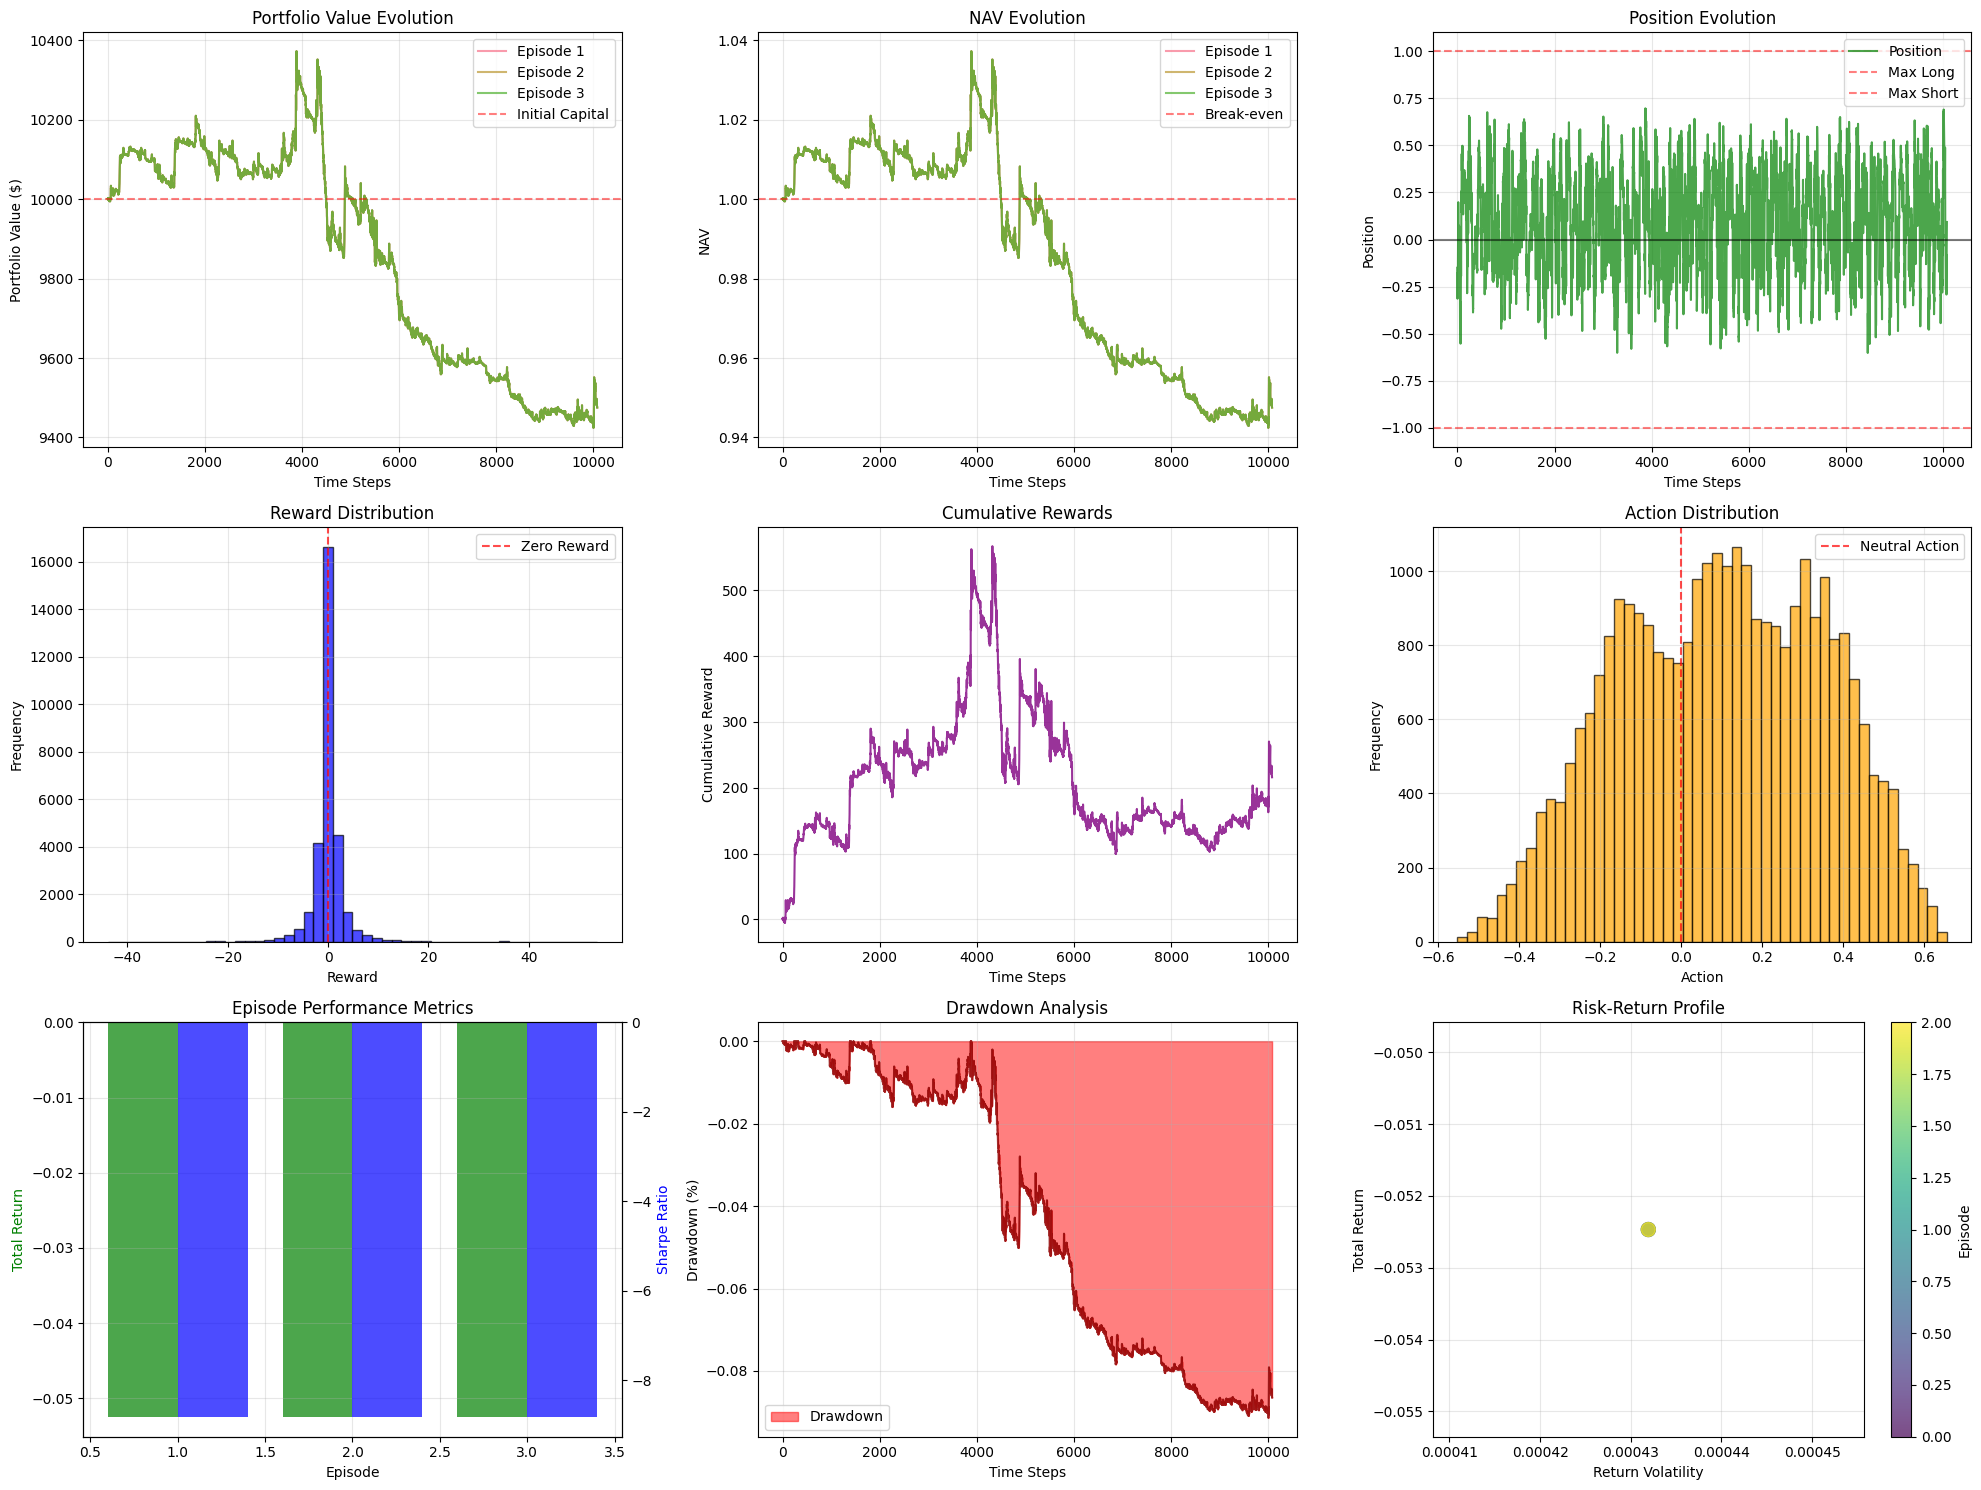

   💾 Price/action/portfolio chart saved to: ./processed_data_15d\price_action_portfolio_20251003_152900.png


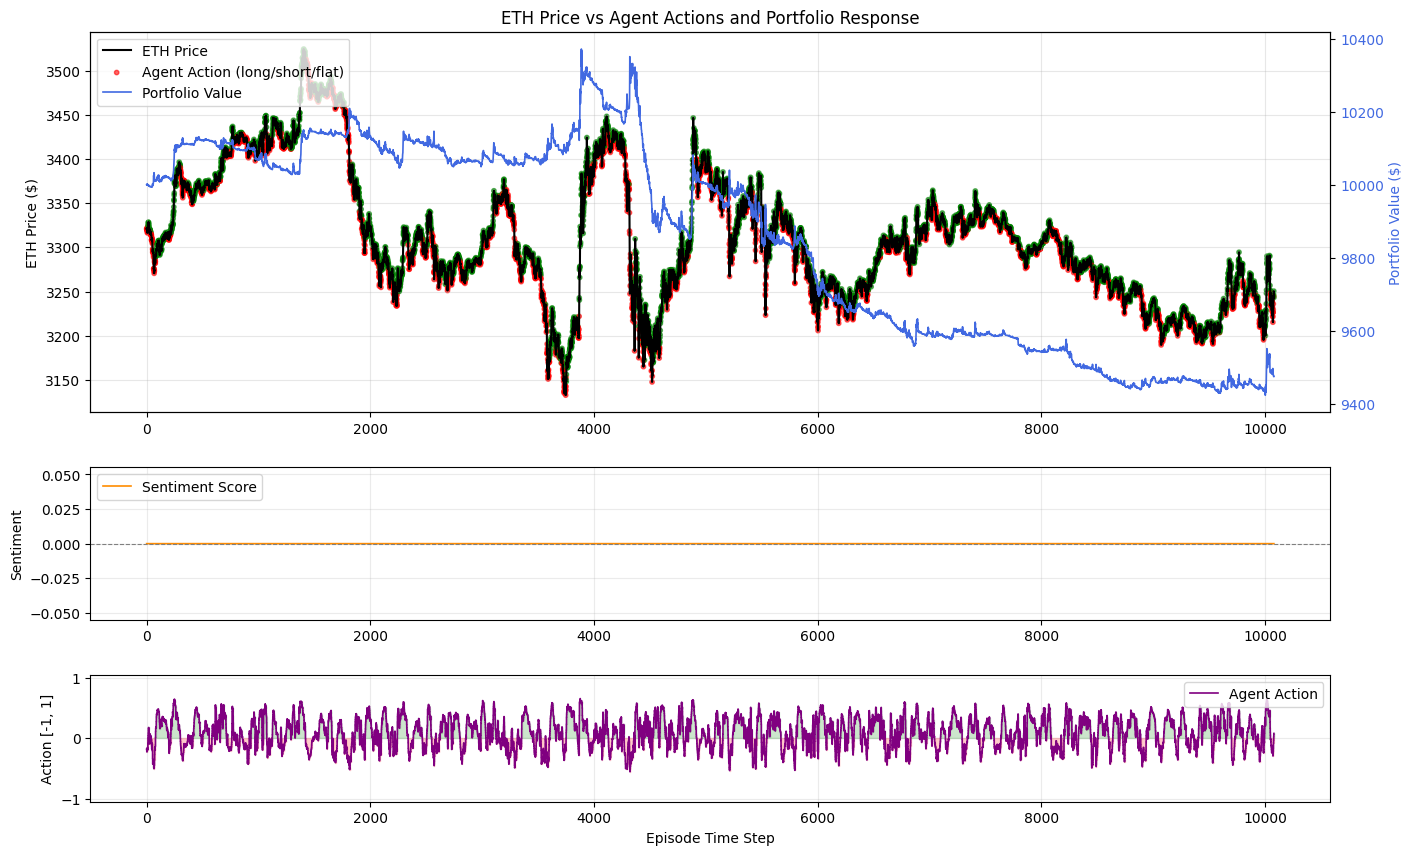

   🎯 Creating reward component analysis...
   💾 Reward component analysis saved to: ./processed_data_15d\reward_components_20251003_152901.png


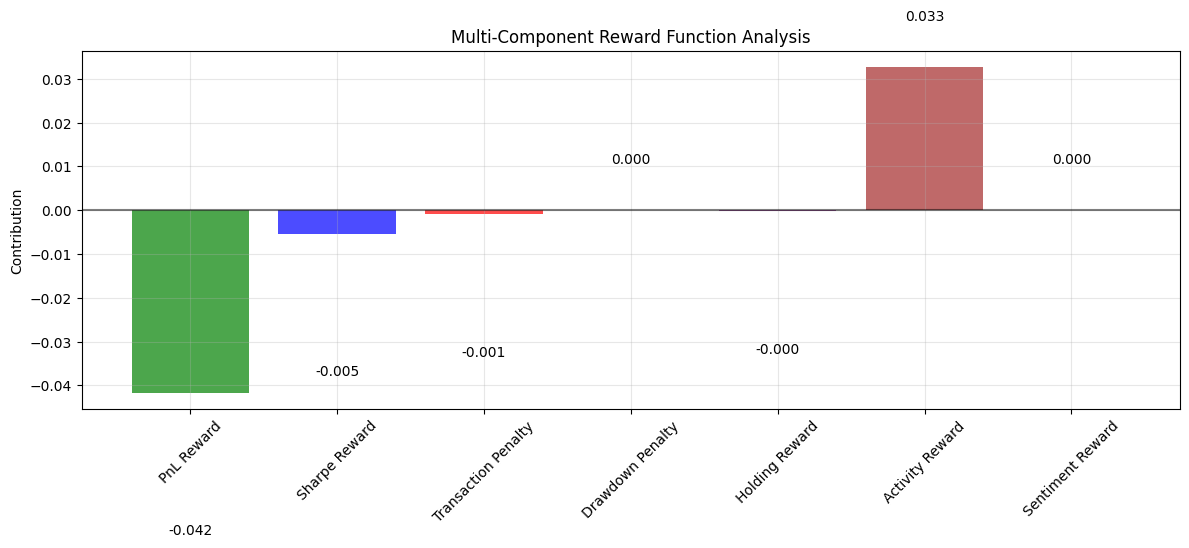

📊 Performance plots generated for debug run.


In [10]:
# ==== 0) 单步限速：最大化 ====
MAX_POSITION_SHIFT = 1.0   # 直接允许一步跳到 ±1

# ==== 1) 全局奖励权重（夸张版）====
REWARD_COMPONENTS.update({
    # PnL 仍主导（保持中等比例，避免其它项被淹没）
    'pnl_scale': 8000.0,
    'pnl_normalization': 'nav',

    # 交易 & 风险（适度，别卡住动作）
    'transaction_penalty': 0.012,
    'fee_rate': 0.001,
    'slippage': 0.0005,
    'drawdown_threshold': 0.15,
    'drawdown_penalty': 0.10,
    'sharpe_weight': 0.30,
    'sharpe_window': 240,
    'sentiment_reward_weight': 0.0,

    # —— 强信号门控：更容易给大步 —— 
    'signal_k': 1.9,          # 目标幅度更激进
    'big_move_k': 1.20,       # ↑ 强信号大步奖励（关键）
    'small_move_k': 0.01,     # ↓ 弱信号大步惩罚（放行尝试）
    'misalign_k': 0.75,       # 反向保持较强惩罚，避免瞎冲

    # —— 仓位幅度/边界吸引：更快贴近±1 —— 
    'pos_size_beta': 0.22,    # ↑ 鼓励做大仓位
    'pos_size_gamma': 2.0,    # ↓ 降低幂次，爬升更平滑
    'edge_start': 0.50,       # ↓ 更早开始吸边界
    'edge_bonus_weight': 0.18,# ↑ 吸边界更强

    # —— 活动项：放宽封顶，让强信号能“助推”更大步 —— 
    'activity_k': 0.5,           # ↑ 基础强度
    'activity_warmup_steps': 2000,# ↓ 更快满功率
    'activity_cap': 0.05,         # ↑ 每步绝对上限
    'activity_rel_cap': 0.90,     # ↑ 允许接近 |PnL| 的贡献
    'activity_signal_boost': 0.5,
    'inactivity_eps': 0.005,
    'inactivity_penalty': 0.005,

    # 抖动/欠量
    'dither_eps': 0.05,
    'dither_penalty': 0.005,
    'underfill_weight': 0.02,  # ↓ 减轻“未达目标”惩罚，避免缩手

        'action_amp_k': 0.8,      # ↑ 强信号大动作的正奖励强度（再猛可到 1.2~1.6）
    'underaction_k': 0.35, 
})




print(">> Global MAX_POSITION_SHIFT:", MAX_POSITION_SHIFT)
# 只打印存在的键，避免 KeyError
_to_show = [
    "pnl_scale","pnl_normalization",
    "drawdown_threshold","drawdown_penalty",
    "transaction_penalty","fee_rate","slippage",
    "activity_k","activity_signal_boost","inactivity_eps","inactivity_penalty",
    "activity_warmup_steps","activity_cap","activity_rel_cap",
    "sharpe_weight","sharpe_window","sentiment_reward_weight",
    "edge_bonus_weight","edge_start",
    "pos_size_beta","pos_size_gamma",
    "signal_k","signal_align_weight",
    "gate_threshold","gate_k","gate_floor",
    "dither_eps","dither_penalty",
    "big_move_k","small_move_k","misalign_k",
    "underfill_weight",
]
_rc = {k: REWARD_COMPONENTS[k] for k in _to_show if k in REWARD_COMPONENTS}
print(">> Global REWARD_COMPONENTS overrides:", _rc)

def merged_reward_config(cfg):
    return REWARD_COMPONENTS.copy()

# ==== 2) 训练配置：加大探索，便于早期尝试大动作 ====
# ==== 2) 训练配置：探索最大化 ====
debug_cfg = {
    "config_id": "debug_run_extreme",
    "algorithm": "A2C",
    "description": "Extreme Plan: MAX step, huge PnL weight, strong edge/size incentives",
    "training": {
        "total_timesteps": 100_000,
        "train_episode_length": 1440*7,
        "eval_episode_length": 10000,
        "rolling_window_months": 12,
    },
    "model_params": {
        "learning_rate": 5e-5,
        "n_steps": 2048,
        "gamma": 0.995,
        "gae_lambda": 0.95,
        "ent_coef": 0.2,       # 极高熵：最大化探索
        "vf_coef": 0.25,
        "max_grad_norm": 0.7,
        "use_sde": True,
        "sde_sample_freq": 4,
        "policy_kwargs": {
            "log_std_init": 1.0,   # 初始动作方差极大
            "ortho_init": False,
            "net_arch": [512, 512], # 更深网络承受更极端奖励
        },
    }
}

# ==== 3) 合并并运行 ====
cfg = debug_cfg.copy()
cfg["reward_components"] = merged_reward_config(cfg)
print("\n>> Effective reward_config:", {k: cfg["reward_components"][k] for k in _to_show if k in cfg["reward_components"]})

algo = cfg["algorithm"].upper()
print(f"🚀 Running debug experiment: {cfg['config_id']} ({algo})")

if algo == "A2C":
    model, train_metrics = trainer.train_a2c_model(cfg, reward_config=cfg["reward_components"])
elif algo == "TD3":
    model, train_metrics = trainer.train_td3_model(cfg, reward_config=cfg["reward_components"])
else:
    raise ValueError(f"Unsupported algorithm: {algo}")

# 保存 + 测试
import os
os.makedirs(MODEL_DIR, exist_ok=True)
save_path = os.path.join(MODEL_DIR, f"{cfg['config_id']}_final")
model.save(save_path)
print(f"💾 Saved {cfg['config_id']} to {save_path}.zip")

test_env = trainer.create_environment(trainer.test_data, reward_config=cfg["reward_components"], random_start=False)
mean_test_reward = trainer.evaluate_model(model, test_env, n_episodes=3)
analysis = analyzer.analyze_model_performance(model=model, env=test_env, n_episodes=3,
                                              config_info={"config_id": cfg["config_id"], "algorithm": algo})
print(f"✅ Debug run complete. Mean test reward: {mean_test_reward:.4f}")
analyzer.create_performance_plots(analysis)
print("📊 Performance plots generated for debug run.")


In [25]:
# ==== 7) 仓位变化可视化（含正负 Δpos） ====
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# 选第 1 个 episode（需要其它就把索引 0 改成 1/2/...）
ep = analysis['episode_data'][0]

positions = np.asarray(ep.get('positions', []), dtype=float)
actions   = np.asarray(ep.get('actions', []), dtype=float)
rewards   = np.asarray(ep.get('rewards', []), dtype=float)
prices    = np.asarray(ep.get('prices', []), dtype=float)  # 若为空则自动跳过价格曲线

if positions.size == 0:
    print("⚠️ 可视化跳过：positions 为空。确认 analyze_model_performance 已成功返回 episode_data。")
else:
    steps = np.arange(len(positions))
    dpos = np.zeros_like(positions)
    if len(positions) > 1:
        dpos[1:] = np.diff(positions)

    # --- 图 1：仓位/动作/Δpos（含正负） ---
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    ax1, ax2, ax3 = axes

    # 1) 仓位曲线
    ax1.plot(steps, positions, linewidth=1.6)
    ax1.axhline(0, color='gray', lw=1, alpha=0.6)
    ax1.axhline(1, color='red', lw=1, ls='--', alpha=0.6)
    ax1.axhline(-1, color='red', lw=1, ls='--', alpha=0.6)
    ax1.set_ylabel('Position')
    ax1.set_title('Position Path (Episode 1)')
    ax1.grid(alpha=0.25)

    # 2) 单步仓位变化 Δpos（保留正负）
    ax2.plot(steps, dpos, linewidth=1.6)
    ax2.axhline(0, color='gray', lw=1, alpha=0.6)
    ax2.set_ylabel('Δpos per step')
    ax2.set_title('Position Change (Episode 1)')
    ax2.grid(alpha=0.25)

    # 3) 动作（模型输出）
    if actions.size == len(steps):
        ax3.step(steps, actions, where='post', linewidth=1.4)
        ax3.axhline(0, color='gray', lw=1, alpha=0.6)
        ax3.set_ylim(-1.05, 1.05)
        ax3.set_ylabel('Action [-1, 1]')
        ax3.set_xlabel('Step')
        ax3.set_title('Agent Action (Episode 1)')
        ax3.grid(alpha=0.25)
    else:
        ax3.text(0.5, 0.5, "No actions captured", ha='center', va='center', transform=ax3.transAxes)
        ax3.axis('off')

    plt.tight_layout()
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    fname1 = f"position_action_dpos_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    fpath1 = os.path.join(OUTPUT_DIR, fname1)
    plt.savefig(fpath1, dpi=200, bbox_inches='tight')
    print(f"✅ 仓位/动作/Δpos 图已保存：{fpath1}")
    plt.show()

    # --- 图 2：价格 + 仓位 + NAV（若需要） ---
    portfolio_vals = np.asarray(ep.get('portfolio_values', []), dtype=float)
    nav_vals       = np.asarray(ep.get('nav_values', []), dtype=float)

    if prices.size > 0 or portfolio_vals.size > 0 or nav_vals.size > 0:
        fig2 = plt.figure(figsize=(16, 9))
        gs = fig2.add_gridspec(3, 1, height_ratios=[3, 1.2, 1], hspace=0.25)

        # 顶部：价格（若有） + 仓位（第二轴显示净值）
        ax_price = fig2.add_subplot(gs[0])
        if prices.size == len(steps):
            ax_price.plot(steps, prices, linewidth=1.5, label="ETH Price")
        ax_price.set_ylabel("Price")
        ax_price.grid(alpha=0.3)

        if portfolio_vals.size == len(steps):
            ax_nav = ax_price.twinx()
            ax_nav.plot(steps, portfolio_vals, linewidth=1.2, label="Portfolio Value")
            ax_nav.set_ylabel("Portfolio ($)")

        # 中部：NAV（若有）
        ax_nav_mid = fig2.add_subplot(gs[1], sharex=ax_price)
        if nav_vals.size == len(steps):
            ax_nav_mid.plot(steps, nav_vals, linewidth=1.4, label='NAV')
            ax_nav_mid.axhline(1.0, color='gray', ls='--', lw=1)
            ax_nav_mid.set_ylabel("NAV")
            ax_nav_mid.legend(loc="upper left")
        else:
            ax_nav_mid.text(0.5, 0.5, "NAV not available", ha='center', va='center', transform=ax_nav_mid.transAxes)
            ax_nav_mid.axis('off')

        # 底部：动作（若有）
        ax_act = fig2.add_subplot(gs[2], sharex=ax_price)
        if actions.size == len(steps):
            ax_act.step(steps, actions, where="post", linewidth=1.2, label="Action")
            ax_act.fill_between(steps, 0, actions, where=actions >= 0, alpha=0.2, step="post")
            ax_act.fill_between(steps, 0, actions, where=actions < 0,  alpha=0.2, step="post")
            ax_act.set_ylim(-1.05, 1.05)
            ax_act.set_ylabel("Action")
            ax_act.set_xlabel("Step")
            ax_act.grid(alpha=0.25)
        else:
            ax_act.text(0.5, 0.5, "No actions captured", ha='center', va='center', transform=ax_act.transAxes)
            ax_act.axis('off')

        fig2.tight_layout()
        fname2 = f"price_portfolio_action_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        fpath2 = os.path.join(OUTPUT_DIR, fname2)
        fig2.savefig(fpath2, dpi=200, bbox_inches="tight")
        print(f"✅ 价格/净值/动作 图已保存：{fpath2}")
        plt.show()



🚀 [0] Training A2C model: A2C_extreme_local_20251003T042617Z_000
✅ EthereumTradingEnvironment initialized
   📊 Data length: 1,318,384 rows
   🎯 State space: 15D (6 core + 8 technical + 1 sentiment)
   🎮 Action space: Continuous [-1, 1]
   📏 Episode length: 10080 minutes
   🔙 Lookback window: 120 minutes
   💰 Initial capital: $10,000
🚦 max_position_shift=1.0
✅ EthereumTradingEnvironment initialized
   📊 Data length: 282,512 rows
   🎯 State space: 15D (6 core + 8 technical + 1 sentiment)
   🎮 Action space: Continuous [-1, 1]
   📏 Episode length: 10080 minutes
   🔙 Lookback window: 120 minutes
   💰 Initial capital: $10,000
🚦 max_position_shift=1.0
🔄 Resuming training from models_a2c_best\A2C_extreme_local_20251003T042617Z_000\best_model.zip


KeyboardInterrupt: 

In [27]:
# ========= 训练范围（支持区间训练）=========
START_IDX = 0
END_IDX   = 50        

# ========= 主循环：逐个配置训练 =========
for idx, cfg in enumerate(configs[START_IDX:END_IDX], start=START_IDX):
    cfg_id = cfg["config_id"]
    print(f"\n🚀 [{idx}] Training A2C model: {cfg_id}")

    # --- 目录 & 路径 ---
    save_dir = MODEL_DIR / cfg_id
    save_dir.mkdir(parents=True, exist_ok=True)
    best_model_path = save_dir / "best_model.zip"
    run_log_dir = LOG_DIR / cfg_id
    run_log_dir.mkdir(parents=True, exist_ok=True)

    if best_model_path.exists():
        print(f"⏩ Skipping {cfg_id}: best_model.zip already exists.")
        continue

    env = trainer.create_environment(
        trainer.train_data,
        reward_config=cfg["reward_components"],
        random_start=True
    )
    eval_env = trainer.create_environment(
        trainer.test_data,
        reward_config=cfg["reward_components"],
        random_start=False
    )

    eval_freq = int(cfg["training"].get("eval_freq", 10_000))
    total_ts  = int(cfg["training"]["total_timesteps"])

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=str(save_dir),
        log_path=str(run_log_dir),
        eval_freq=eval_freq,
        n_eval_episodes=3,
        deterministic=True,
        render=False
    )

    print("🆕 Starting new training")
    model_params = dict(cfg["model_params"])
    model = A2C("MlpPolicy", env, **model_params, verbose=1, device="cpu")
    model.learn(total_timesteps=total_ts, callback=[eval_callback])

    if best_model_path.exists():
        best_model = A2C.load(str(best_model_path), env=eval_env, device="cpu")
        best_nav = quick_eval_nav(best_model, eval_env)
    else:
        best_nav = quick_eval_nav(model, eval_env)

    result_entry = {
        "config_id": cfg_id,
        "best_model_path": str(best_model_path),
        "best_eval_nav": to_jsonable(best_nav),
        "total_timesteps": to_jsonable(total_ts),
        "eval_freq": to_jsonable(eval_freq),
        "timestamp": int(time.time()),
    }
    result_entry["model_params"] = to_jsonable(cfg.get("model_params", {}))
    result_entry["training"] = to_jsonable(cfg.get("training", {}))
    result_entry["reward_components"] = to_jsonable(cfg.get("reward_components", {}))

    results_log[cfg_id] = result_entry

    with open(RESULTS_FILE, "w") as f:
        json.dump(results_log, f, indent=2)

    print(f"✅ Results saved for {cfg_id} | best_eval_nav={best_nav:.4f}")

    # --- 关闭环境 ---
    try:
        env.close()
    except Exception:
        pass
    try:
        eval_env.close()
    except Exception:
        pass

print("\n🎯 全部任务完成，汇总文件:", RESULTS_FILE)



🚀 [0] Training A2C model: A2C_extreme_local_20251003T042617Z_000
⏩ Skipping A2C_extreme_local_20251003T042617Z_000: best_model.zip already exists.

🚀 [1] Training A2C model: A2C_extreme_local_20251003T042617Z_001
⏩ Skipping A2C_extreme_local_20251003T042617Z_001: best_model.zip already exists.

🚀 [2] Training A2C model: A2C_extreme_local_20251003T042617Z_002
⏩ Skipping A2C_extreme_local_20251003T042617Z_002: best_model.zip already exists.

🚀 [3] Training A2C model: A2C_extreme_local_20251003T042617Z_003
✅ EthereumTradingEnvironment initialized
   📊 Data length: 1,318,384 rows
   🎯 State space: 15D (6 core + 8 technical + 1 sentiment)
   🎮 Action space: Continuous [-1, 1]
   📏 Episode length: 10080 minutes
   🔙 Lookback window: 120 minutes
   💰 Initial capital: $10,000
🚦 max_position_shift=1.0
✅ EthereumTradingEnvironment initialized
   📊 Data length: 282,512 rows
   🎯 State space: 15D (6 core + 8 technical + 1 sentiment)
   🎮 Action space: Continuous [-1, 1]
   📏 Episode length: 10080

TypeError: Object of type type is not JSON serializable